# Постановка задачи

### Задача

- Поиск аномалий в банковских транзакциях. Построить unsupervised модель поиска аномалий в данных

### Описание данных

**Источник данных:** https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

**Описание датасета:**
Аномальных значений в данных меньше одного процента. Переменные анонимизированные и представляют собой первые 28 главных компонент, полученных после PCA преобразования оригинальных данных (о которых нет данных).

In [22]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
#plt.style.use("seaborn-dark")
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})




import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option("display.max_columns", 50)

import numpy as np

import seaborn as sns
sns.set_style("darkgrid")  
sns.set_context("talk", font_scale=0.6)

import matplotlib
import matplotlib.pyplot as plt
#plt.style.use("seaborn-dark")
matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"})

from tqdm import tqdm

import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def plot_numUFA(df: pd.DataFrame, num_columns: list=None):
    
    assert num_columns!=None, 'Не передан список числовых признаков'

    skewness_list = df[num_columns].skew()
    
    subplot_cnt = len(num_columns)*3
    
    
    n_col = 3
    if len(num_columns) <= n_col/3:
        n_col = 3
        n_row = 1
    else:
        n_row = math.ceil(subplot_cnt / n_col)
    

    fig, axes = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(n_col * 6, n_row * 6),
        gridspec_kw={"hspace": 0.4, "wspace": 0.2, "width_ratios": [0.8, 0.5, 1]},
    )
    axes = axes.flatten()
    i = 0
    for column in tqdm(num_columns):

         # __Распределение__
        ax = axes[i]
        sns.kdeplot(data=df, 
                    x=column, 
                    ax=ax, 
                    fill=False, 
                    alpha=0.9, 
                    legend=False, 
                    linewidth=3, 
                    palette = 'Set2',
                   )

        skewness = skewness_list[column]
        ax.text(
            ax.get_xlim()[0],
            ax.get_ylim()[-1],
            f"skew: {skewness:.2f}",
            size=12,
            weight="bold",
        )
        i = i+1



        #__Бокс__
        ax = axes[i]
        sns.boxplot(
            data=df,
            #x="Churn",
            y=column,
            ax=ax,
            width=0.6,
            saturation=0.9,
            linewidth=0.9,
            palette='Set2',
        )

        i =i + 1



        # __Монотонность__
        df_local = df.copy()
        df_local = df_local.sort_values(by=column).reset_index(drop=True)
        ax = axes[i]
        sns.scatterplot(
            data=df_local, x=df_local.index, y=column,alpha=1, ax=ax, color='b', palette='Set2'
        )
        i = i+1

In [46]:
def my_subplots(subplot_cnt: int, n_col: int = 3):
    '''
    Построение грид графиков.
    Кол-во строк определяется автоматически
    :param subplot_cnt: Список графиков
    :param n_col: int = 3 Количество столбцов
    :return: fig, ax: list
    '''

    # ___Step_1___
    # Определение кол. строк и столбцов
    if subplot_cnt <= n_col:
        n_col = subplot_cnt
        n_row = 1
    else:
        n_row = math.ceil(subplot_cnt / n_col)

    # ___Step_2___
    # Построение графика
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col * 6, n_row * 6), gridspec_kw={"hspace": 0.4, "wspace": 0.2})
    if n_row > 1:
        ax = ax.reshape(ax.shape[0] * ax.shape[1], )
    if subplot_cnt == 1:
        # Создание итерабельного объекта
        ax = [ax]

    return fig, ax

# <font color=#0b5bdb> Загрузка данных

In [2]:
df = pd.read_pickle('../data/df_sampled.pkl')
display(df.head())
display(df.tail())

Time        V1        V2        V3        V4        V5        V6  \
0  121834.0  1.677091 -0.614929 -1.832890  0.715216 -0.036954 -0.645886   
1   87929.0  0.156840  0.839646  0.219472 -0.314089  0.481671 -1.388000   
2   60619.0  1.237276  0.100418  0.630819  0.876132 -0.535018 -0.573740   
3   97506.0  2.054514 -0.185909 -1.187650  0.354062  0.143950 -0.459099   
4   66227.0 -0.760424  0.215761  1.372878  0.787424  0.875127 -0.857475   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.158482 -0.100677  0.964742 -0.529193  0.496287  0.295714 -1.329143   
1  1.247261 -0.507503  0.153192 -0.067952 -0.481991 -0.165671 -0.446792   
2 -0.067294 -0.160084  0.460378 -0.241473 -0.612242  1.025970  0.979927   
3 -0.108728 -0.274690  2.412178 -0.584591 -0.288737 -2.007052  1.717358   
4 -0.013656  0.092919 -0.550835 -0.408690 -0.014552 -0.167921 -0.114334   

        V14       V15       V16       V17       V18       V19       V20  \
0 -0.722116 -0.875095  0.085371  0.567313  0.948051  0.345839  0.062242   
1  0.315819  0.541119 -0.690208 -0.350463 -0.048648 -0.183396  0.010933   
2 -0.400826 -0.515170 -0.414135  0.028038 -0.691597  0.183798 -0.067815   
3  1.432188 -1.132392 -0.601330  0.580904 -0.081454  0.154600 -0.222395   
4 -0.173204  1.702257 -0.306794  0.670162 -0.381147  0.568077  0.241776   

        V21       V22       V23       V24       V25       V26       V27  \
0  0.145028  0.295575 -0.186692 -0.420242  0.186678 -0.156919 -0.028914   
1  0.348161  1.439081 -0.108080  0.431096 -0.898259 -0.270005  0.347814   
2 -0.080328  0.081396 -0.096403  0.482440  0.624283  0.435247 -0.008014   
3 -0.082136  0.288284  0.045730  0.580895  0.224099  0.130758 -0.059283   
4 -0.079987 -0.422860  0.206257  0.030319 -0.723075  0.184528  0.120487   

        V28  Amount Class  
0 -0.016659  172.77     0  
1  0.102353    3.55     0  
2  0.012167    1.00     0  
3 -0.061639   15.66     0  
4  0.176923    0.99     0

Time        V1        V2        V3        V4        V5        V6  \
14235  128108.0  0.700651 -2.961016 -3.374825  0.038504 -0.425715 -0.855577   
14236   58517.0  1.432538 -1.134162  0.027881 -1.468238 -1.119989 -0.491285   
14237   54246.0  0.737305  0.133545  1.216831  1.362514 -0.976640  0.007792   
14238   19892.0  1.338298 -0.500849  0.526264 -0.431351 -0.765004 -0.239927   
14239  163622.0  0.051805  0.781816  0.210365 -0.608462  0.387406 -1.070308   

             V7        V8        V9       V10       V11       V12       V13  \
14235  1.420779 -0.621410 -1.386693  0.864553  0.561343 -0.009263 -0.826617   
14236 -0.754633 -0.276250 -1.958475  1.375347 -1.045341 -0.585825  1.723910   
14237 -0.420231  0.294835  0.645300  0.121668  0.906531  0.843736 -0.531814   
14238 -0.670635 -0.134269  0.478043  0.256491  1.901204 -1.822023  2.478570   
14239  0.931904 -0.136590  0.128966 -0.378331 -1.241921 -0.482088 -1.038424   

            V14       V15       V16       V17       V18       V19       V20  \
14235  1.233544 -0.849655 -1.932567  0.007689  1.387843 -0.624506  0.940651   
14236 -0.552639  0.521466 -0.196484  0.145003  0.117014  0.040284 -0.078001   
14237 -0.182919 -0.489109  0.047338 -0.283545  0.612091  0.457989 -0.125289   
14238  0.985846 -1.991304  0.802710  0.996778 -0.991057  1.136589  0.117180   
14239  0.317423 -0.274508 -0.000024 -0.400708 -0.568566 -0.020905 -0.102776   

            V21       V22       V23       V24       V25       V26       V27  \
14235  0.410194 -0.077007 -0.745147  0.852564  0.168120  0.882897 -0.285038   
14236 -0.211269 -0.331208 -0.148402 -0.432855  0.507731 -0.166408  0.021401   
14237  0.119923  0.507465  0.362641  0.500498 -1.025001 -0.561959  0.033304   
14238 -0.120031 -0.045208 -0.101955 -0.007399  0.568069 -0.284739 -0.015477   
14239 -0.282538 -0.686737  0.063991 -0.146656 -0.505945  0.151055  0.239979   

            V28  Amount Class  
14235  0.040265  795.52     0  
14236  0.028110   89.70     0  
14237 -0.114165   27.00     0  
14238 -0.001445   30.00     0  
14239  0.093659    2.69     0

 - Данные загрузились успешно

# <font color=#0b5bdb> 1. Общий взгляд

## <font color=#0b5bdb>1.1 Типы данных

In [3]:
# Реализовать как функцию
def display_dtypes(df):
    df_local = df
    df_tmp = df_local#[[i for i in df_local.columns if 'datetime' in i]]

    # Обзор намеков на типы признаков
    unique_values = df_tmp.nunique().sort_values(ascending=False)
    unique_values = pd.DataFrame(unique_values, columns = ['Колич. уник. значений'])

    # Довать процентовку
    unique_values['Доля в %'] = (unique_values['Колич. уник. значений']/df_tmp.shape[0])*100
    unique_values = pd.concat([unique_values, pd.DataFrame(df_tmp.dtypes, columns=['dtype'])], axis=1) 
    display(unique_values)
    
display_dtypes(df)

Колич. уник. значений   Доля в %    dtype
V15                     14170  99.508427  float64
V28                     14170  99.508427  float64
V26                     14170  99.508427  float64
V25                     14170  99.508427  float64
V24                     14170  99.508427  float64
V23                     14170  99.508427  float64
V22                     14170  99.508427  float64
V21                     14170  99.508427  float64
V20                     14170  99.508427  float64
V19                     14170  99.508427  float64
V18                     14170  99.508427  float64
V17                     14170  99.508427  float64
V16                     14170  99.508427  float64
V1                      14170  99.508427  float64
V14                     14170  99.508427  float64
V13                     14170  99.508427  float64
V12                     14170  99.508427  float64
V11                     14170  99.508427  float64
V10                     14170  99.508427  float64
V9                      14170  99.508427  float64
V8                      14170  99.508427  float64
V7                      14170  99.508427  float64
V6                      14170  99.508427  float64
V5                      14170  99.508427  float64
V4                      14170  99.508427  float64
V3                      14170  99.508427  float64
V2                      14170  99.508427  float64
V27                     14170  99.508427  float64
Time                    13523  94.964888  float64
Amount                   5528  38.820225  float64
Class                       2   0.014045   object

**Заключение**
 - Типы всех признаков соответствуют заявленным
 - Неинформативные признаки отсутствуют

## <font color=#0b5bdb> 1.2. Проверка наличия дыр в данных

In [4]:
import missingno as msno


# Процентный список пропущенных значений
def scan_miss_val(df: pd.DataFrame) -> pd.DataFrame:
    '''
    :param df:
    :return: На выходе столбец значений =(% NAN) в признаке.
    '''
    # ___init___
    miss_val_df = pd.DataFrame()
    NA_present = 0

    # Обработка каждого столбца отдельно
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        temp = pd.DataFrame([round(pct_missing * 100)], columns=['% miss'], index=[col])
        temp['cnt'] = df[col].isnull().sum()

        miss_val_df = pd.concat([miss_val_df, temp], axis=0)

        if (pct_missing != 0) & (NA_present == 0):
            NA_present = NA_present + 1

    # Построение Тепловой карты пропущенных значений
    if NA_present != 0:
        msno.matrix(df, labels=True, sort="descending")

    return miss_val_df.sort_values(by='% miss')

In [5]:
scan_miss_val(df)

% miss  cnt
Time         0    0
V28          0    0
V27          0    0
V26          0    0
V25          0    0
V24          0    0
V23          0    0
V22          0    0
V21          0    0
V20          0    0
V19          0    0
V18          0    0
V17          0    0
V16          0    0
Amount       0    0
V15          0    0
V13          0    0
V12          0    0
V11          0    0
V10          0    0
V9           0    0
V8           0    0
V7           0    0
V6           0    0
V5           0    0
V4           0    0
V3           0    0
V2           0    0
V1           0    0
V14          0    0
Class        0    0

**Заключение**
 - В данных отстутсвуют пропущенные значения

## <font color=#0b5bdb> 1.3. Области допустимых значений признаков (поиск ошибок в данных).

### <font color=#0b5bdb> 1.3.1 Числовые признаки

In [6]:
df.describe().drop(['count', 'std', 'mean'], axis=0)

Time         V1         V2         V3         V4         V5  \
min       0.00 -36.510583 -40.938048 -32.965346  -4.837170 -42.147898   
25%   54453.25  -0.908903  -0.619214  -0.899831  -0.854730  -0.708459   
50%   84499.00   0.043716   0.039203   0.174182  -0.000585  -0.069634   
75%  138460.75   1.316283   0.789399   1.044500   0.760836   0.598014   
max  172768.00   2.411499  18.183626   3.812871  11.864868  16.878967   

            V6         V7         V8        V9        V10       V11  \
min -12.709475 -22.518547 -41.484823 -6.310658 -13.202577 -3.290420   
25%  -0.766579  -0.562053  -0.215123 -0.639139  -0.539425 -0.765427   
50%  -0.276332   0.030853   0.019041 -0.049601  -0.092873 -0.053308   
75%   0.392260   0.559267   0.318554  0.610425   0.460547  0.727263   
max  22.529298  36.677268  18.709255  8.911164  13.644460  9.815703   

           V12       V13        V14       V15        V16        V17       V18  \
min -15.531611 -3.881106 -16.337596 -3.704928 -12.375397 -21.090613 -7.724546   
25%  -0.408887 -0.656700  -0.423900 -0.586953  -0.478902  -0.482629 -0.486483   
50%   0.134213 -0.022087   0.048018  0.047089   0.055616  -0.062351 -0.000615   
75%   0.613040  0.666824   0.493284  0.654612   0.520353   0.390155  0.497551   
max   4.846452  4.469566   6.991753  3.822504   6.098529   7.293108  4.029395   

          V19        V20        V21       V22        V23       V24       V25  \
min -3.834534 -22.838548 -20.262054 -8.887017 -13.700719 -2.493545 -3.223535   
25% -0.465446  -0.212514  -0.226669 -0.536214  -0.163236 -0.345618 -0.311631   
50% -0.009239  -0.064511  -0.025309  0.015608  -0.014353  0.045991  0.019150   
75%  0.449185   0.133826   0.188527  0.538405   0.150749  0.434188  0.352667   
max  4.606007  13.530721  27.202839  5.805795  15.879421  3.569702  7.519589   

          V26        V27        V28    Amount  
min -1.603645  -8.839766  -9.617915     0.000  
25% -0.333563  -0.069376  -0.051578     6.000  
50% -0.058466   0.002306   0.011791    23.295  
75%  0.241040   0.091581   0.080627    79.000  
max  2.689352  11.135740  22.620072  7429.150

 **Заключение**
  - В данных отсутствуют явные ошибки в значениях

### <font color=#0b5bdb> 1.3.2 Категориальные (object) признаки

In [7]:
df.describe(include=object)

Class
count   14240
unique      2
top         0
freq    14218

In [9]:
df['Class'].unique()

array(['0', '1'], dtype=object)

 **Заключение**
  - В данных отсутствуют явные ошибки в значениях

## <font color=#0b5bdb> 1.4 Наличие дубликатов </font>

In [10]:
# Сканирование на наличие дубликатов
columns_to_concider = df.columns
df_duplicated = df.duplicated(subset=columns_to_concider)

n_duplicates = df_duplicated.sum()
print('Number of duplicates = ', n_duplicates)

display(df[df_duplicated==True])

Number of duplicates =  5


Time        V1        V2        V3        V4        V5        V6  \
7531    82654.0 -4.643503  2.036761 -0.297092 -0.403318 -0.402646 -0.313817   
9174    55439.0 -0.570064  3.080779 -0.029533 -1.692420 -4.193967  1.254051   
9462    65183.0  1.138580 -0.151257  0.706147  1.274886  0.117396  1.722669   
10494  163152.0 -1.203617  1.574009  2.889277  3.381404  1.538663  3.698747   
11965   82654.0 -4.643503  2.036761 -0.297092 -0.403318 -0.402646 -0.313817   

             V7        V8        V9       V10       V11       V12       V13  \
7531   0.802498 -0.077243  2.548294  4.170287  1.175621  1.122182  0.637834   
9174   3.402755  0.170399 -0.890587 -1.104567  1.356334  1.001239  0.454602   
9462  -0.587792  0.450392  0.905769 -0.279291 -0.421860  1.853891  1.072050   
10494  0.560211 -0.150911  0.124136  4.220998  1.384569 -0.706897 -0.256274   
11965  0.802498 -0.077243  2.548294  4.170287  1.175621  1.122182  0.637834   

            V14       V15       V16       V17       V18       V19       V20  \
7531  -1.486609 -0.760113 -0.351821 -0.691092 -0.344916  0.571762  0.639584   
9174   0.534895 -0.494574  1.022639 -0.614173 -0.223276 -0.319667 -1.283559   
9462  -0.863982 -2.436099 -0.610252 -0.037983 -0.561706  0.969046 -0.083976   
10494 -1.562583  1.692915 -0.787338 -0.226776 -0.412354  0.234322  1.385597   
11965 -1.486609 -0.760113 -0.351821 -0.691092 -0.344916  0.571762  0.639584   

            V21       V22       V23       V24       V25       V26       V27  \
7531  -1.000309 -0.226106  0.384968  0.035079  0.765632  0.140652 -0.305543   
9174  -0.509122 -0.042721  0.367427  0.618789 -0.135566  0.734012  0.996069   
9462  -0.441145 -0.757700 -0.108389 -1.314834  0.617970 -0.445921  0.094076   
10494 -0.366727  0.522223 -0.357329 -0.870174 -0.134166  0.327019 -0.042648   
11965 -1.000309 -0.226106  0.384968  0.035079  0.765632  0.140652 -0.305543   

            V28  Amount Class  
7531  -0.211450   43.05     0  
9174  -0.278841  799.00     0  
9462   0.006733    7.89     0  
10494 -0.855262    1.51     0  
11965 -0.211450   43.05     0

In [11]:
df_duplicated = df[df_duplicated==True]

In [15]:
temp_df = df_duplicated[df_duplicated['Class'] == '0']
display(temp_df.describe())

Time        V1        V2        V3        V4        V5  \
count       5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean    89816.400000 -1.984421  1.715411  0.594341  0.431447 -0.668640   
std     42630.154237  2.574132  1.180594  1.347011  1.956918  2.124822   
min     55439.000000 -4.643503 -0.151257 -0.297092 -1.692420 -4.193967   
25%     65183.000000 -4.643503  1.574009 -0.297092 -0.403318 -0.402646   
50%     82654.000000 -1.203617  2.036761 -0.029533 -0.403318 -0.402646   
75%     82654.000000 -0.570064  2.036761  0.706147  1.274886  0.117396   
max    163152.000000  1.138580  3.080779  2.889277  3.381404  1.538663   

             V6        V7        V8        V9       V10       V11       V12  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   1.209567  0.996034  0.063079  1.047181  2.235543  0.934057  0.878520   
std    1.666033  1.463358  0.248345  1.511095  2.688365  0.764280  0.948512   
min   -0.313817 -0.587792 -0.150911 -0.890587 -1.104567 -0.421860 -0.706897   
25%   -0.313817  0.560211 -0.077243  0.124136 -0.279291  1.175621  1.001239   
50%    1.254051  0.802498 -0.077243  0.905769  4.170287  1.175621  1.122182   
75%    1.722669  0.802498  0.170399  2.548294  4.170287  1.356334  1.122182   
max    3.698747  3.402755  0.450392  2.548294  4.220998  1.384569  1.853891   

            V13       V14       V15       V16       V17       V18       V19  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.509209 -0.972978 -0.551597 -0.215719 -0.452223 -0.377434  0.405445   
std    0.484465  0.888936  1.473040  0.716412  0.301150  0.123546  0.481674   
min   -0.256274 -1.562583 -2.436099 -0.787338 -0.691092 -0.561706 -0.319667   
25%    0.454602 -1.486609 -0.760113 -0.610252 -0.691092 -0.412354  0.234322   
50%    0.637834 -1.486609 -0.760113 -0.351821 -0.614173 -0.344916  0.571762   
75%    0.637834 -0.863982 -0.494574 -0.351821 -0.226776 -0.344916  0.571762   
max    1.072050  0.534895  1.692915  1.022639 -0.037983 -0.223276  0.969046   

            V20       V21       V22       V23       V24       V25       V26  \
count  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000  5.000000   
mean   0.259446 -0.663522 -0.146082  0.134329 -0.299212  0.375900  0.179283   
std    1.006979  0.311540  0.459402  0.346632  0.778414  0.470145  0.425269   
min   -1.283559 -1.000309 -0.757700 -0.357329 -1.314834 -0.135566 -0.445921   
25%   -0.083976 -1.000309 -0.226106 -0.108389 -0.870174 -0.134166  0.140652   
50%    0.639584 -0.509122 -0.226106  0.367427  0.035079  0.617970  0.140652   
75%    0.639584 -0.441145 -0.042721  0.384968  0.035079  0.765632  0.327019   
max    1.385597 -0.366727  0.522223  0.384968  0.618789  0.765632  0.734012   

            V27       V28    Amount  
count  5.000000  5.000000    5.0000  
mean   0.087282 -0.310054  178.9000  
std    0.536527  0.323274  347.1837  
min   -0.305543 -0.855262    1.5100  
25%   -0.305543 -0.278841    7.8900  
50%   -0.042648 -0.211450   43.0500  
75%    0.094076 -0.211450   43.0500  
max    0.996069  0.006733  799.0000

**Заключение**
- В данных имеются дубликаты записей.
- Учитывая отсутствие содержательной информации об транзакциях, не можем точно сказать, что это чистые дубликаты. По своей природе транзакции могут повторяться и их частота повторений может быть признаком

# <font color=#0b5bdb> 2. EDA: Numeric_FA

In [17]:
numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
display(numeric_cols)

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [18]:
df_numeric = df[numeric_cols]

## <font color=#0b5bdb> 2.2 Univariate FA

### <font color=#0b5bdb> 2.2.1 Descriptive Statitics

<font color=#0b5bdb> ___Обзор статистик___

In [19]:
df_descibe = df_numeric.describe()

df_descibe.loc[['min', 'mean', '50%', 'max']]

Time         V1         V2         V3         V4         V5  \
min        0.000000 -36.510583 -40.938048 -32.965346  -4.837170 -42.147898   
mean   94787.347683   0.015991  -0.017241  -0.000612  -0.000453  -0.014591   
50%    84499.000000   0.043716   0.039203   0.174182  -0.000585  -0.069634   
max   172768.000000   2.411499  18.183626   3.812871  11.864868  16.878967   

             V6         V7         V8        V9        V10       V11  \
min  -12.709475 -22.518547 -41.484823 -6.310658 -13.202577 -3.290420   
mean  -0.001955  -0.003043  -0.021354  0.009517   0.000433 -0.012131   
50%   -0.276332   0.030853   0.019041 -0.049601  -0.092873 -0.053308   
max   22.529298  36.677268  18.709255  8.911164  13.644460  9.815703   

            V12       V13        V14       V15        V16        V17  \
min  -15.531611 -3.881106 -16.337596 -3.704928 -12.375397 -21.090613   
mean  -0.001246 -0.002250  -0.001638 -0.002573  -0.002820  -0.005556   
50%    0.134213 -0.022087   0.048018  0.047089   0.055616  -0.062351   
max    4.846452  4.469566   6.991753  3.822504   6.098529   7.293108   

           V18       V19        V20        V21       V22        V23       V24  \
min  -7.724546 -3.834534 -22.838548 -20.262054 -8.887017 -13.700719 -2.493545   
mean  0.008005 -0.006922  -0.007247   0.003115  0.003273   0.001385  0.006294   
50%  -0.000615 -0.009239  -0.064511  -0.025309  0.015608  -0.014353  0.045991   
max   4.029395  4.606007  13.530721  27.202839  5.805795  15.879421  3.569702   

           V25       V26        V27        V28       Amount  
min  -3.223535 -1.603645  -8.839766  -9.617915     0.000000  
mean  0.002720 -0.003044  -0.000185   0.007003    89.406706  
50%   0.019150 -0.058466   0.002306   0.011791    23.295000  
max   7.519589  2.689352  11.135740  22.620072  7429.150000

**Заключение**
- Вероятно наличие сильного скоса влево признака **Amount**.
- Вероятно наличие сильного скоса вправо в признаках **V1, V3**

### <font color=#0b5bdb> 2.2.2 Visual analis

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.00it/s]


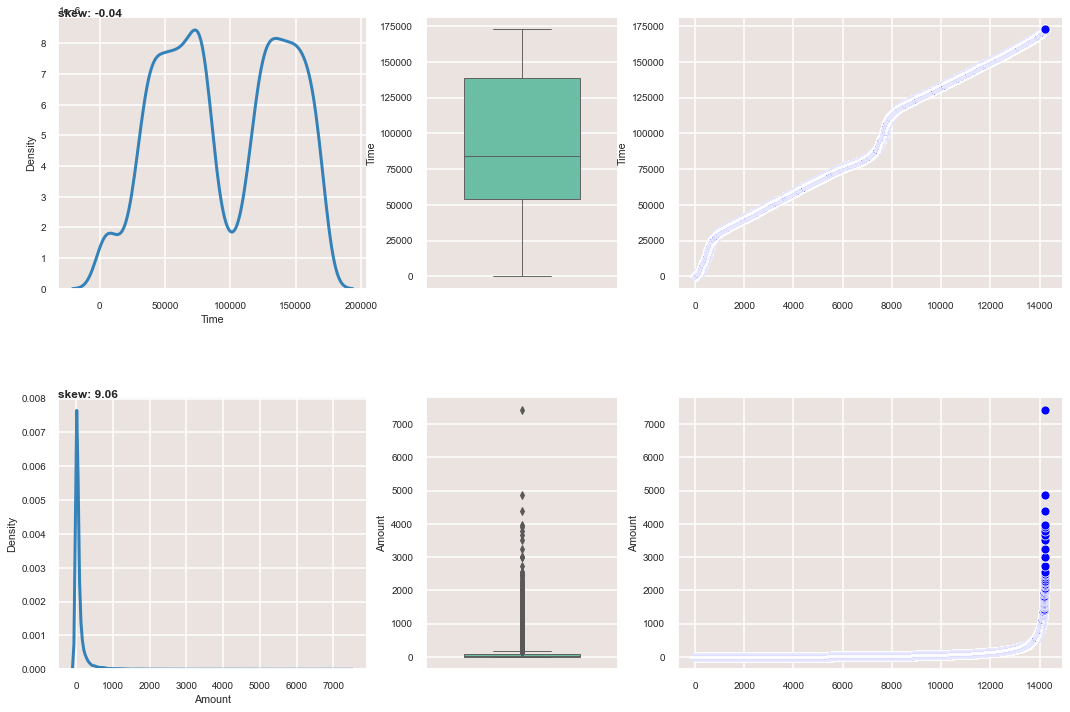

In [23]:
plot_numUFA(df_numeric, num_columns=['Time', 'Amount'])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.28it/s]


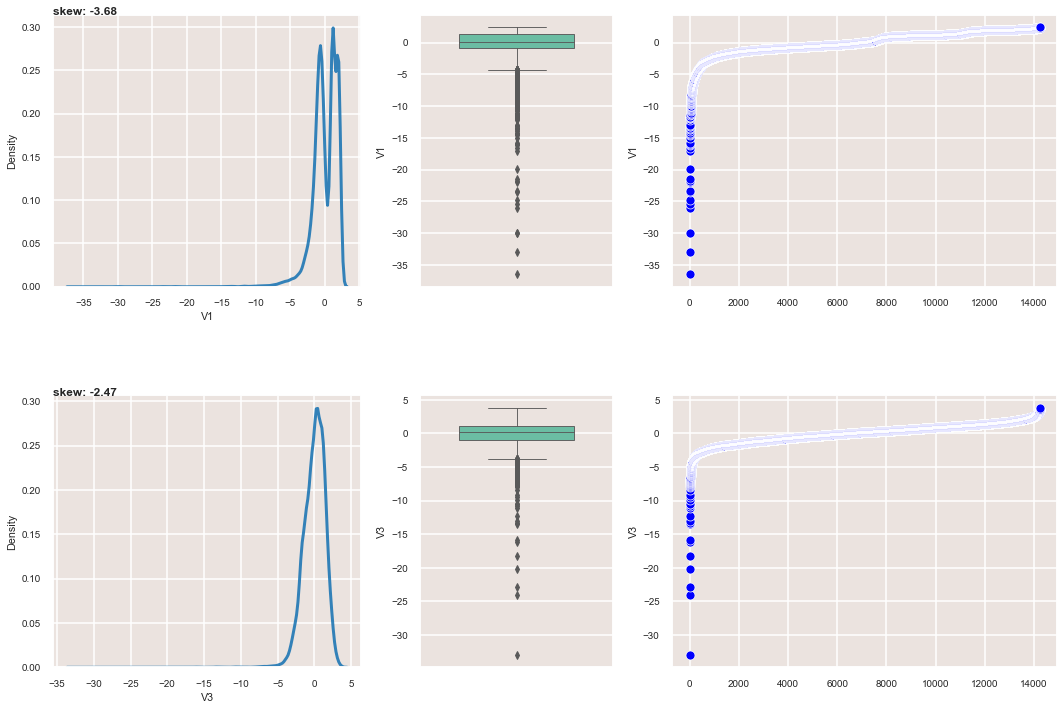

In [24]:
plot_numUFA(df_numeric, num_columns=['V1', 'V3'])

**Заключение**
- Видим подтверждение наличия сильного скоса влево признака **Amount**.
- Видим подтверждение наличия сильного скоса вправо в признаках **V1, V3**
- Признак **Time** имеет явное двумодальное распределение.

## <font color=#0b5bdb> 2.3 Bivariate numFA

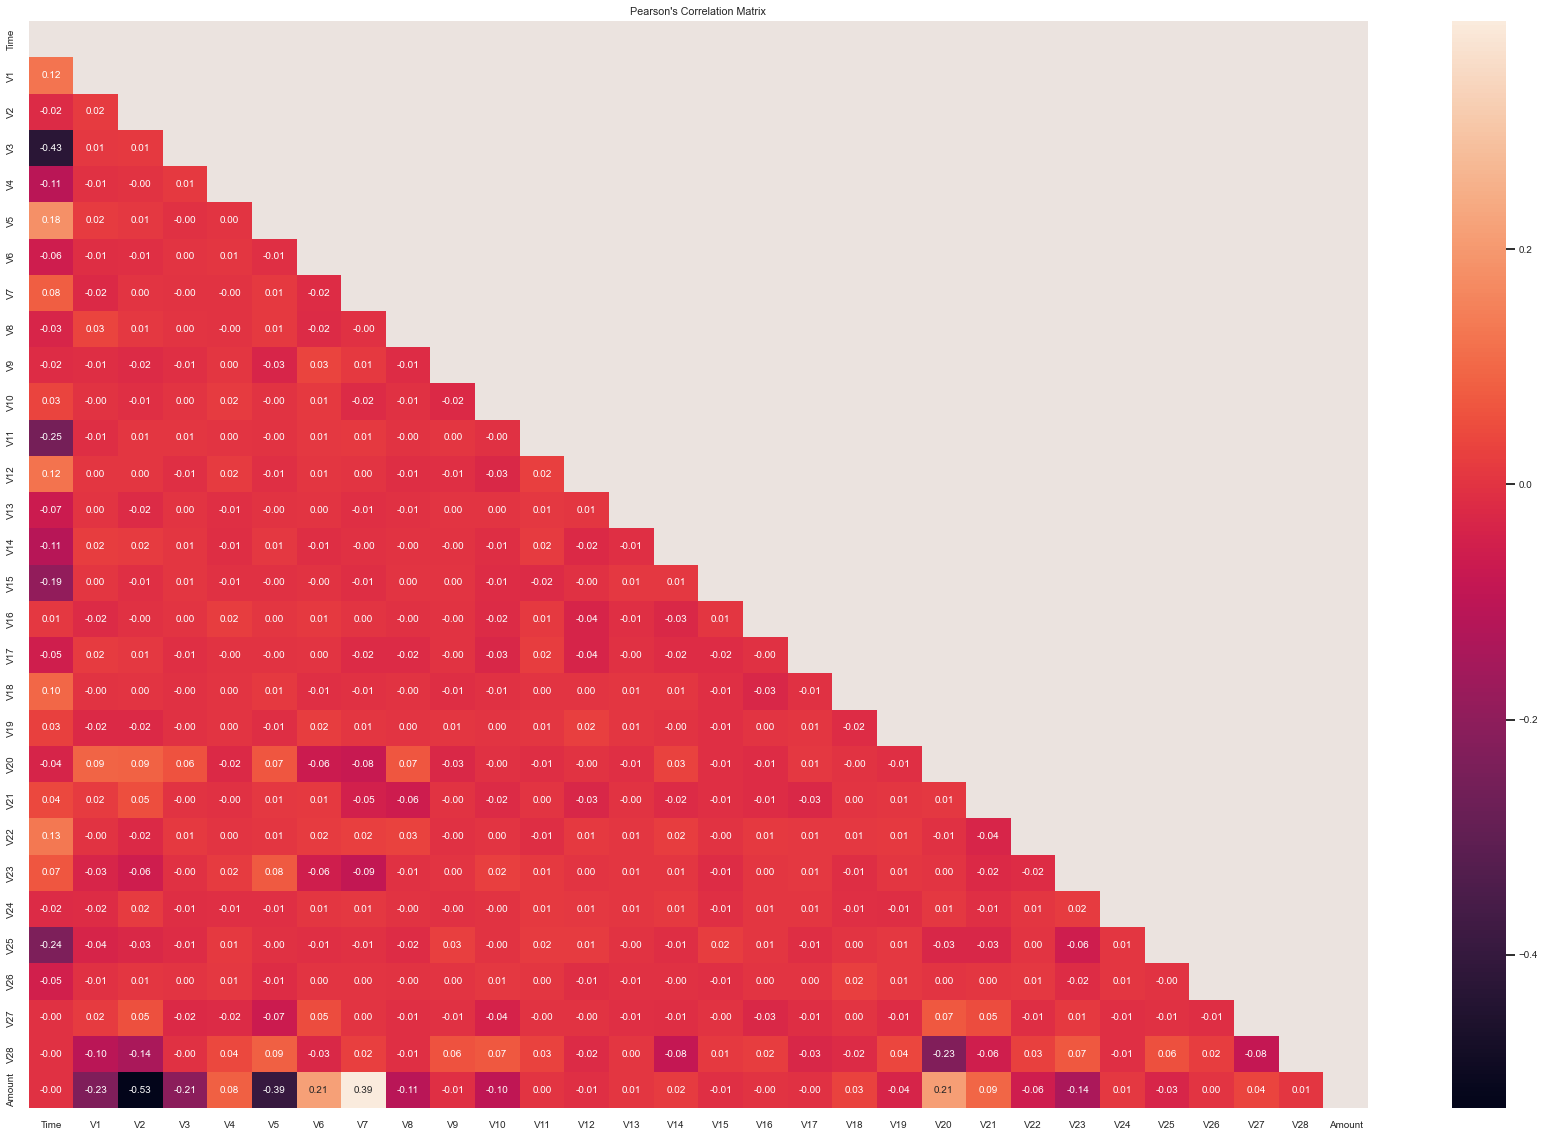

In [25]:
corr = df_numeric.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

**Заключение**
 - Как и ожидалось, корреляция между **V..** (PCA) признаками близка к нулю.
 - Выделяются слабая корреляция (0.53) между признаками **Amount** и **V2** и слабая корреляция (0.42) между признаками **Time** и **V3**. 

# <font color=#0b5bdb> 3. EDA: Target view

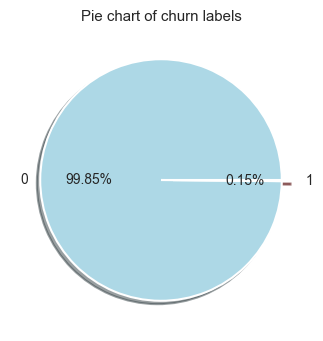

In [26]:
churn_label_count = df["Class"].value_counts()
fig = plt.figure(figsize=(7, 4), dpi=100)
plt.pie(
    churn_label_count,
    autopct="%.2f%%",
    labels=churn_label_count.index,
    colors=["lightblue", "red"],
    explode=[0, 0.1],
    shadow=True,
)
plt.title("Pie chart of churn labels")
plt.show()

**Заключение**
 - Наблюдаем сильный дисбаланс целевого признака. Доля размеченных аномалий меньше 1%.

# <font color=#0b5bdb> 3. Anomaly_detection

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.spatial.distance import cdist

from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

from sklearn.base import BaseEstimator, TransformerMixin

- Отделим признак **Class** для реализации **Unsupervised fraud detection task**
- Процентом аномалий, подсчитанным по признаку **Class**, воспользуемся как "экспертной оценкой" загрязненности нашего датасета.
- Из признака **Class** сформируем y_true DF для анализа результатов.

In [28]:
X = df.drop(columns=['Class', 'Time'])
display(X.info())

y_true = df['Class'].copy()
display(y_true.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14240 entries, 0 to 14239
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      14240 non-null  float64
 1   V2      14240 non-null  float64
 2   V3      14240 non-null  float64
 3   V4      14240 non-null  float64
 4   V5      14240 non-null  float64
 5   V6      14240 non-null  float64
 6   V7      14240 non-null  float64
 7   V8      14240 non-null  float64
 8   V9      14240 non-null  float64
 9   V10     14240 non-null  float64
 10  V11     14240 non-null  float64
 11  V12     14240 non-null  float64
 12  V13     14240 non-null  float64
 13  V14     14240 non-null  float64
 14  V15     14240 non-null  float64
 15  V16     14240 non-null  float64
 16  V17     14240 non-null  float64
 17  V18     14240 non-null  float64
 18  V19     14240 non-null  float64
 19  V20     14240 non-null  float64
 20  V21     14240 non-null  float64
 21  V22     14240 non-null  float64
 22

None

0    14218
1       22
Name: Class, dtype: int64

## <font color=#0b5bdb> 3.1. Preprocessing

Т.к. большинство unsupervised методов базируются на рассчете расстояний между объектами, проведем следующую подготовку данных:
   - Проведем нормализацию данных по результатам EDA;
   - Приведем к ортонормированному виду методом PCA.

### <font color=#0b5bdb> 3.1.1 Нормализация

 - По результатам EDA проведем нормализацию признаков **Amount**, **V1**, **V3**

In [31]:
from sklearn.preprocessing import PowerTransformer

def get_bestNorm_transf(df: pd.DataFrame, column_name: str):
    df_local = df[[column_name]].copy()
    
    if df_local.min()[0]<=0:
        # применяем преобразование Йео–Джонсона
        power = PowerTransformer(method='yeo-johnson', standardize=False)
        power.fit(df_local)
        df_local[f'tr({column_name})'] = power.transform(df_local)
    else:
        # применяем преобразование Йео–Джонсона
        power = PowerTransformer(method='box-cox', standardize=False)
        power.fit(df_local)
        df_local[f'tr({column_name})'] = power.transform(df_local)
    
    print(f'Преобразование признака {column_name}:')
    print(f'lambda = {power.lambdas_[0]}:')
    print(f"Скос:    {df_local[column_name].skew().round(3)} -> {df_local[f'tr({column_name})'].skew().round(3)}")
    print(f"Эксцесс: {df_local[column_name].kurtosis().round(3)} -> {df_local[f'tr({column_name})'].kurtosis().round(3)}")
    
    return df_local[f'tr({column_name})']

from sklearn.preprocessing import PowerTransformer

def plot_bestNorm_transf(df: pd.DataFrame, column_name: str):
    df_local = df[[column_name]].copy()
    
    df_local[f'tr({column_name})'] = get_bestNorm_transf(df, column_name=column_name)
    plot_numUFA(df_local, num_columns=list(df_local.columns))
    plt.show()
    
    return df_local[f'tr({column_name})']

Преобразование признака Amount:
lambda = -0.03942602086211029:
Скос:    9.056 -> 0.016
Эксцесс: 150.052 -> -0.735


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.97it/s]


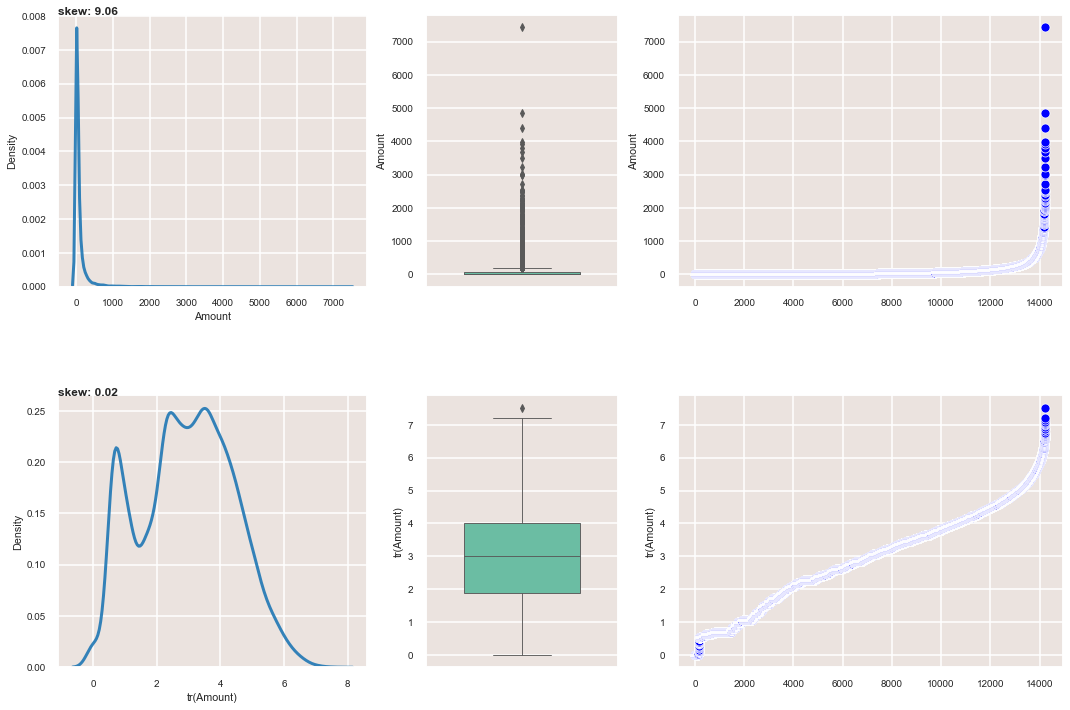

Преобразование признака V1:
lambda = 1.4935985937839273:
Скос:    -3.676 -> -0.222
Эксцесс: 38.083 -> 0.05


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.80it/s]


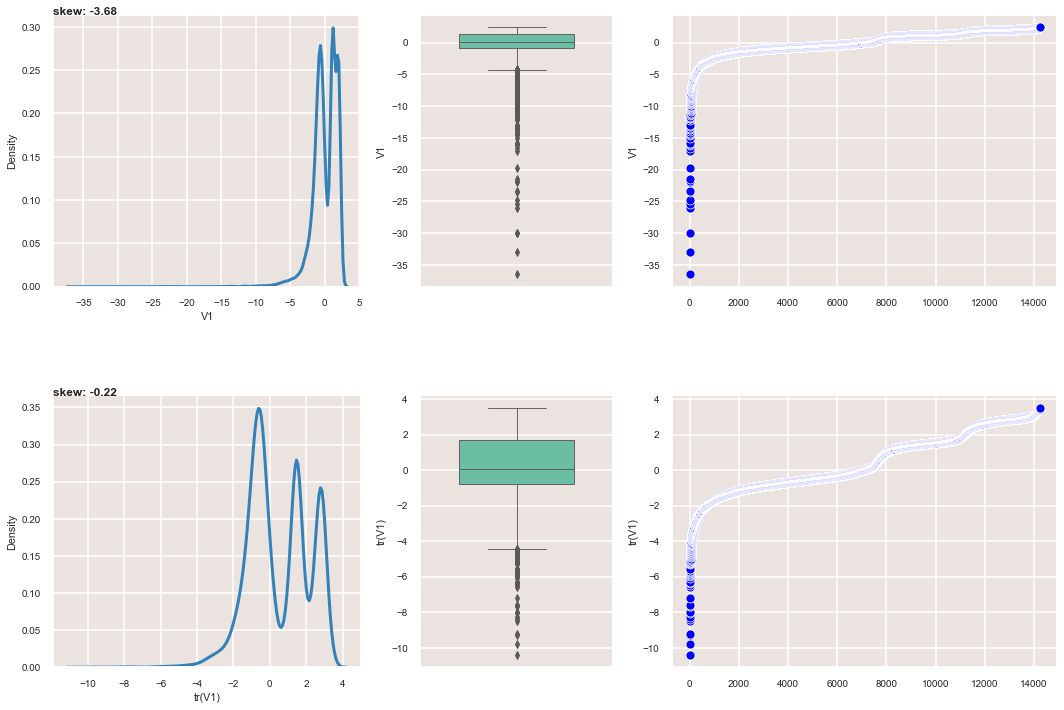

Преобразование признака V3:
lambda = 1.3465245161010688:
Скос:    -2.471 -> -0.097
Эксцесс: 30.965 -> 1.7


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.70it/s]


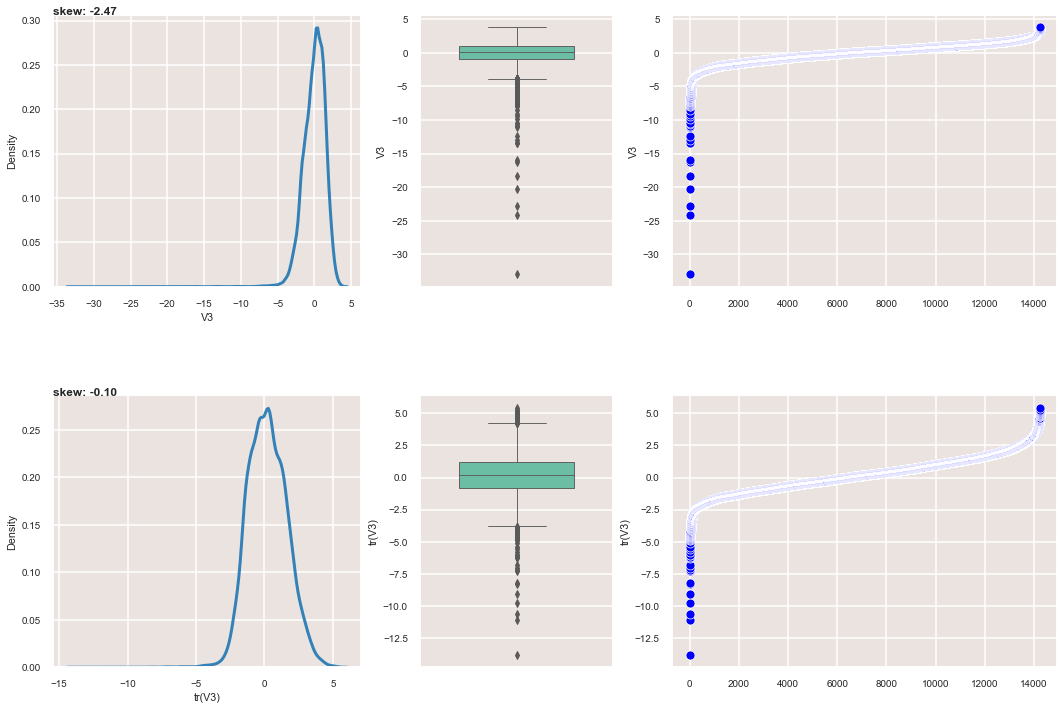

In [32]:
X_norm = X.copy()
columns = ['Amount', 'V1', 'V3']
for col in columns:
    X_norm[col] = plot_bestNorm_transf(X, column_name=col)

**Заключение**
 - Наблюдаем значительное уменьшение skew и kurtosis у преобразованных признаков

### <font color=#0b5bdb> 3.1.2 Ортонормирование (PCA)

In [33]:
from sklearn.decomposition import PCA

def plot_PCA_Explorer (X_scaled, n_components=None):
    pca = PCA(n_components)
    temp = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(10,10))
    
    exp_var = pca.explained_variance_ratio_ * 100
    cum_exp_var = np.cumsum(exp_var)

    plt.bar(list(range(1, len(pca.get_feature_names_out())+1)), exp_var, align='center', label='Individual explained variance')
    plt.step(list(range(1, len(pca.get_feature_names_out())+1)), cum_exp_var, label='Inqdividual explained variance', linewidth=3, color='red')
    plt.xticks(ticks=list(range(1, len(pca.get_feature_names_out())+1)))
    plt.yticks(ticks=list(range(10, 105, 5)))

def PCA_transformation(X:pd.DataFrame, n_components: int):
    df_local = X.copy()
    
    PCA_local = PCA(n_components=n_components)
    df_local = PCA_local.fit_transform(df_local)
    df_local = pd.DataFrame(df_local, columns=PCA_local.get_feature_names_out())
    df_local.head()
    
    return df_local

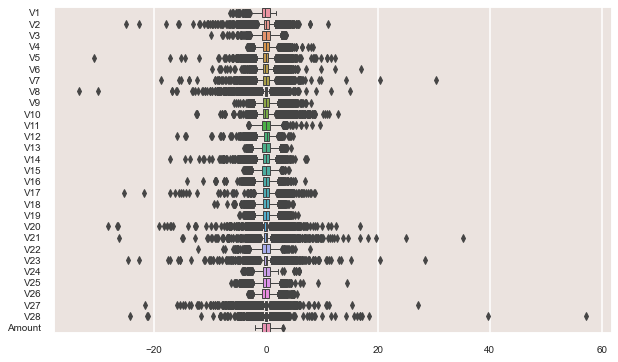

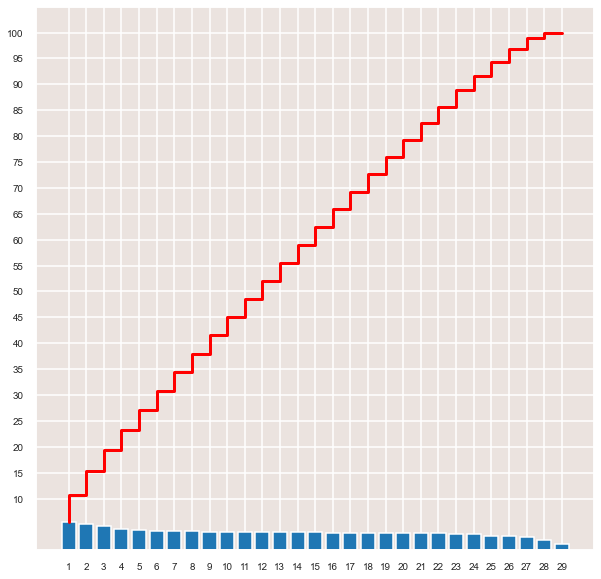

In [34]:
# Подготовка данных (стандартизация) и построение распределения дисперсий после PCA

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
scaler.fit(X_norm)
X_norm_scaled = pd.DataFrame(scaler.transform(X_norm), columns = scaler.get_feature_names_out())

plt.figure(figsize=(10,6))
sns.boxplot(data=X_norm_scaled, orient='h')

plot_PCA_Explorer(X_norm_scaled)

In [35]:
# Преобразование
X_norm_PCA = PCA_transformation(X_norm, n_components=29)

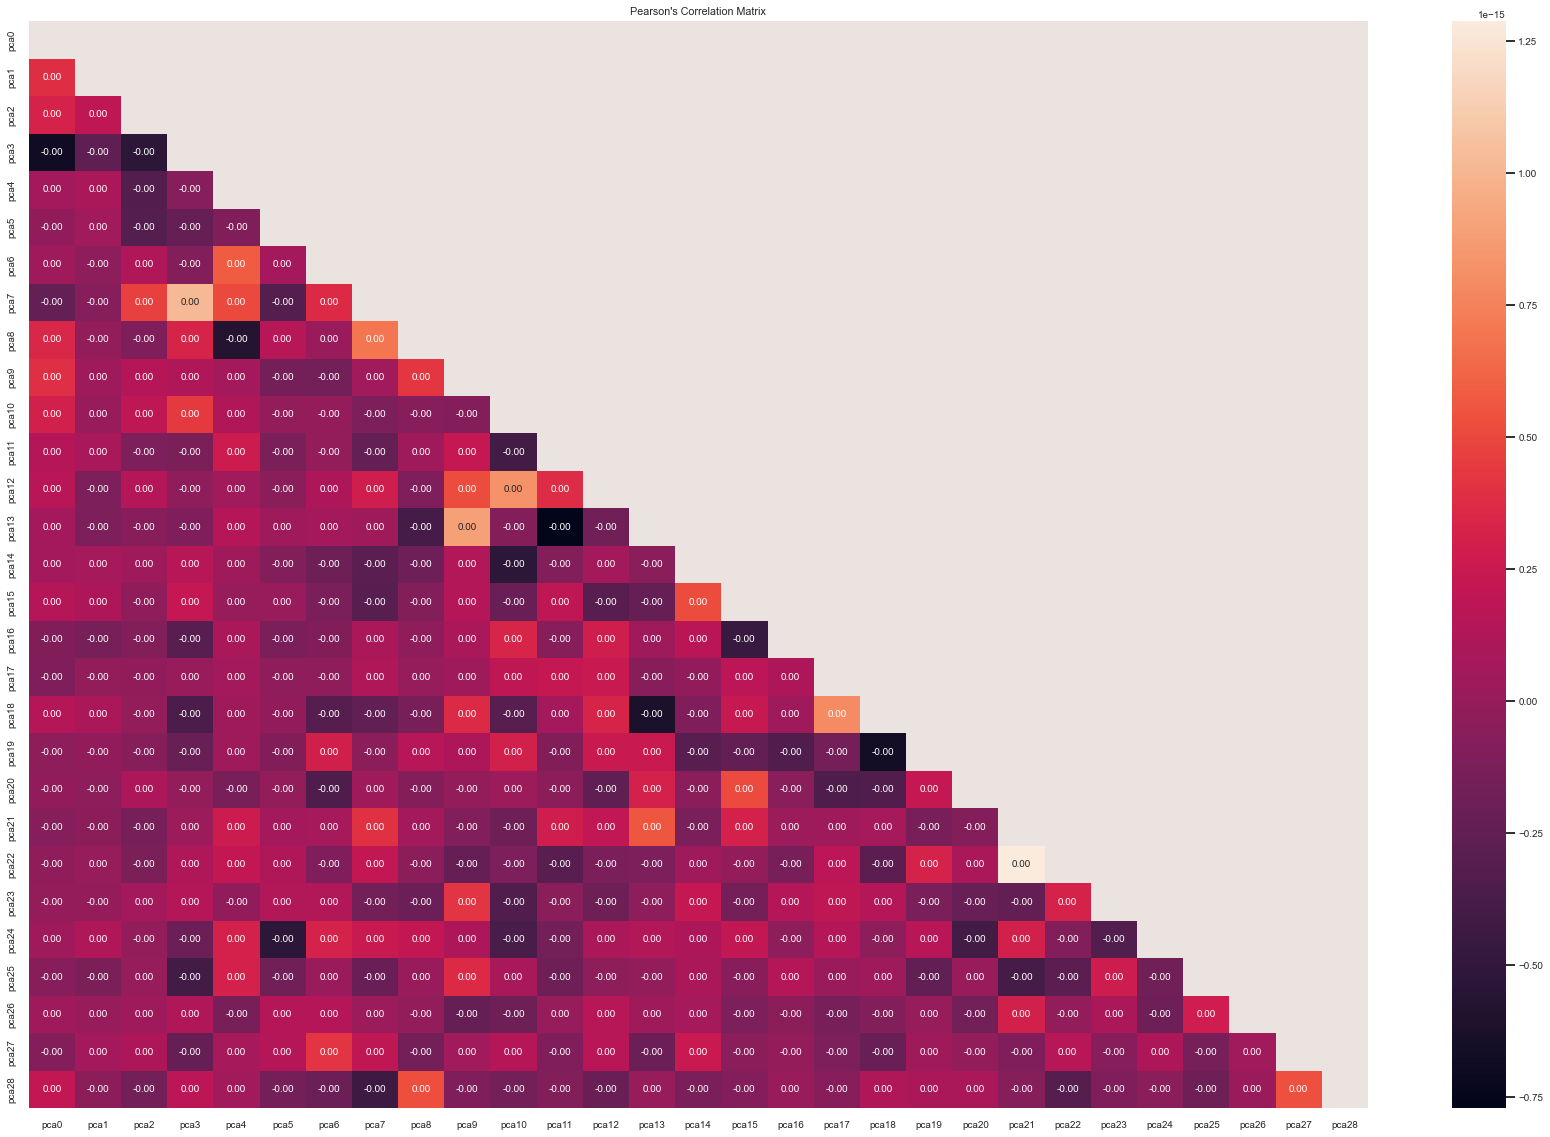

In [36]:
# Проверка ортонормировки

corr = X_norm_PCA.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

**Заключение**
 - Наблюдаем преобразование к системе ЛНЗ векторов

<AxesSubplot:>

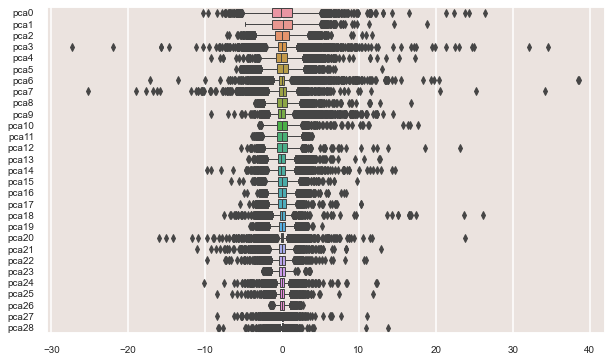

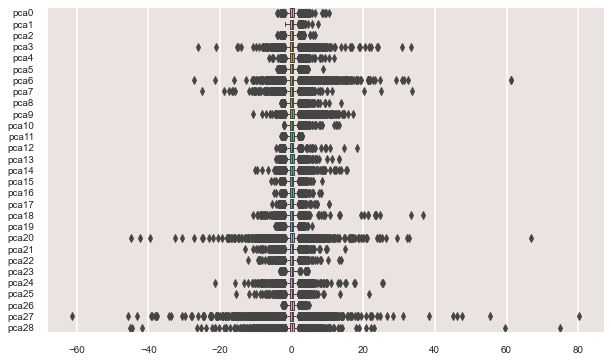

In [41]:
# Robust Scaler
from sklearn.preprocessing import RobustScaler

plt.figure(figsize=(10,6))
sns.boxplot(data=X_norm_PCA, orient='h')

scaler_Rob = RobustScaler()
scaler_Rob.fit(X_norm_PCA)
X_norm_PCA_Rob = pd.DataFrame(scaler_Rob.transform(X_norm_PCA), columns = scaler_Rob.get_feature_names_out())
    
plt.figure(figsize=(10,6))
sns.boxplot(data=X_norm_PCA_Rob, orient='h')

## <font color=#0b5bdb> 3.2. Уменьшение размерности

<font color=#0b5bdb> ___TSNE___

In [42]:
from sklearn.manifold import TSNE

def get_TSNE_DimRed (X, perplexity_list: list = None):

    TSNE_dict = {}
    
    if perplexity_list is None:
        perplexity_list = [20, 30, 50]
    
    for i in perplexity_list:
        tsne = TSNE(
            n_components=2,
            perplexity=i
        )
        TSNE_dict[i] = pd.DataFrame(tsne.fit_transform(X), columns=['TSNE_1', 'TSNE_2'])
        
    return TSNE_dict

def plot_DimRed (DimRed_dict, target: pd.Series=None):
                
    figure, axes = my_subplots(subplot_cnt=len(DimRed_dict.keys()))

    for idx, key in enumerate (list(DimRed_dict.keys())):
        if idx < len(DimRed_dict.keys()):
            ax = axes[idx]
            DimRed_transformed = DimRed_dict[key].values
            sns.scatterplot(x= DimRed_transformed[:, 0], y = DimRed_transformed[:, 1], hue=target, 
                            ax=ax, palette='Set2')
            ax.set_title(str(key))

In [43]:
TSNE_dict = get_TSNE_DimRed(X_norm_PCA_Rob)

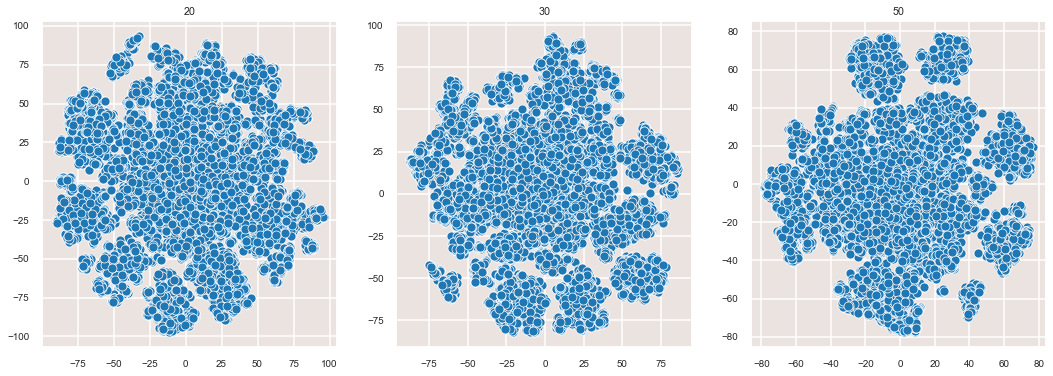

In [47]:
plot_DimRed(TSNE_dict)

<font color=#0b5bdb> ___UMAP___

In [156]:
import umap

def get_UMAP_DimRed (X, n_neighbors_list: list = None):

    UMAP_dict = {}
    reducer = umap.UMAP()
    
    if n_neighbors_list is None:
        n_neighbors_list = [i for i in range(2,20,2)]
    
    for i in n_neighbors_list:
        reducer = umap.UMAP(n_neighbors=i)
        UMAP_dict[i] = pd.DataFrame(reducer.fit_transform(X), columns=['UMAP_1', 'UMAP_2'])
        
    return UMAP_dict

In [160]:
UMAP_dict = get_UMAP_DimRed(X_norm_PCA_Rob, n_neighbors_list=[3, 6, 12, 18, 24])

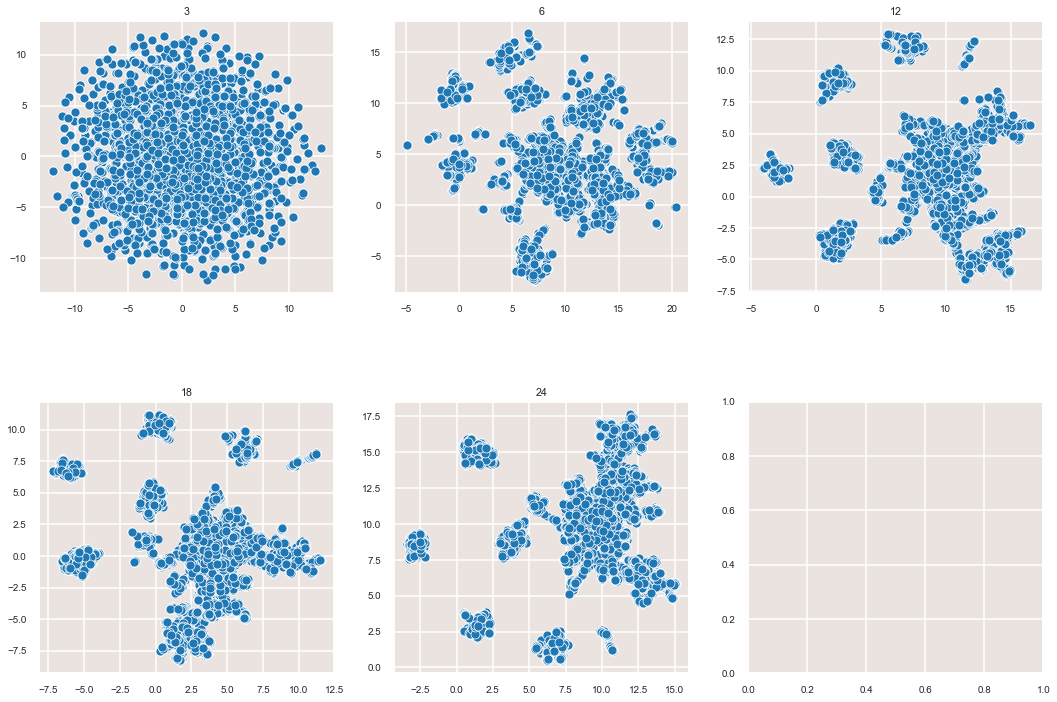

In [161]:
plot_DimRed(UMAP_dict)

## <font color=#0b5bdb> 3.2. IQR_base anomaly

<font color=#0b5bdb> ___Построение оценок___

In [94]:
def get_IQR(df: pd.DataFrame, threshold: float = 1.5) -> dict:
    # ___init___
    df_local = df.copy()

    IQR_dict = {}
    bounds_dict= {}
    # ___Step_1___
    # Обработка по столбцам
    for col in df_local.columns:
        # ___Step_1.1___
        # Формирование уровней доверия
        data = df_local[col]

        data_Q3 = data.quantile(0.75)
        data_Q1 = data.quantile(0.25)
        data_IQR = data_Q3 - data_Q1
        data_Upper = data_Q3 + threshold * data_IQR
        data_Down = data_Q1 - threshold * data_IQR

        # ___Step_1.2___
        # Отбор индексов за границами уровней доверия (выше и ниже)
        outliers_list = list(data[data > data_Upper].index)
        outliers_list.extend(list(data[data < data_Down].index))
        bounds_dict[col] = [data_Upper, data_Down, len(outliers_list)]
        # ___Step_1.3___
        # Заносим списки в словари по столбцам
        IQR_dict[col] = outliers_list

    return IQR_dict, bounds_dict

def get_agg_IQR(df: pd.DataFrame, IQR_dict: dict, threshold: int=0) -> pd.DataFrame:
    # Объединям все списки выбросов
    IQR_list = []
    for col in IQR_dict.keys():
        IQR_list.extend(IQR_dict[col])

    # Отбираем индексы по threshold
    union_IQR = pd.Series(IQR_list).value_counts()
    union_IQR = union_IQR.loc[union_IQR>=threshold]

    # Разметка объектов фрейма и вывод столбца выбросов
    outl_col = pd.DataFrame([1 if i in union_IQR.index else 0 for i in df.index], columns=['IQR_outl'])
    outl_col_weighed = pd.DataFrame([union_IQR.loc[i]/(df.shape[1]) if i in union_IQR.index else 0 for i in df.index], columns=['IQR_weighed'])
    return outl_col, outl_col_weighed, union_IQR

In [95]:
X_to_clean = X_norm.copy()

IQR_dict, bounds_table = get_IQR(X_to_clean, threshold=1.5)
IQR_outl_col, IQR_outl_col_weighed, union_IQR = get_agg_IQR(X_to_clean, IQR_dict, threshold=1)
IQR_outl_col_weighed.sort_values(by='IQR_weighed', ascending=False)

IQR_weighed
13901     0.758621
6105      0.724138
10253     0.724138
13985     0.689655
734       0.689655
...            ...
6133      0.000000
6134      0.000000
6135      0.000000
6137      0.000000
14239     0.000000

[14240 rows x 1 columns]

In [101]:
# Отбор целевого % аномалий

outl_percent = 1
outl_index_list = list(IQR_outl_col_weighed['IQR_weighed'].sort_values(ascending=False).head(int((df.shape[0])*outl_percent/100)).index)

IQR_outl_col = pd.DataFrame(X_norm_PCA_Rob.index, columns=['IQR_outl']).isin(outl_index_list)
IQR_outl_col['IQR_outl'] = IQR_outl_col['IQR_outl'].map({False:0, True:1})

IQR_outl_col.value_counts(normalize=True)

IQR_outl
0           0.990028
1           0.009972
dtype: float64

<font color=#0b5bdb> ___Визуализация___

array([[<AxesSubplot:title={'center':'IQR_weighed'}>]], dtype=object)

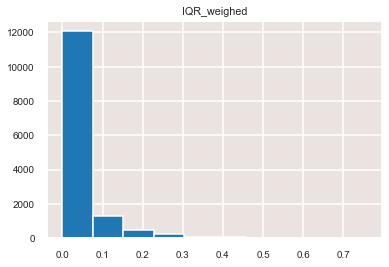

In [102]:
IQR_outl_col_weighed.hist()

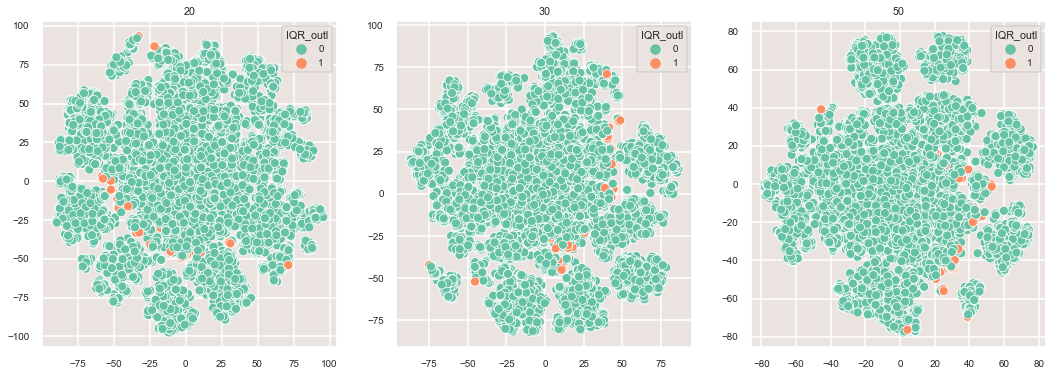

In [103]:
plot_DimRed(TSNE_dict, target=IQR_outl_col['IQR_outl'])

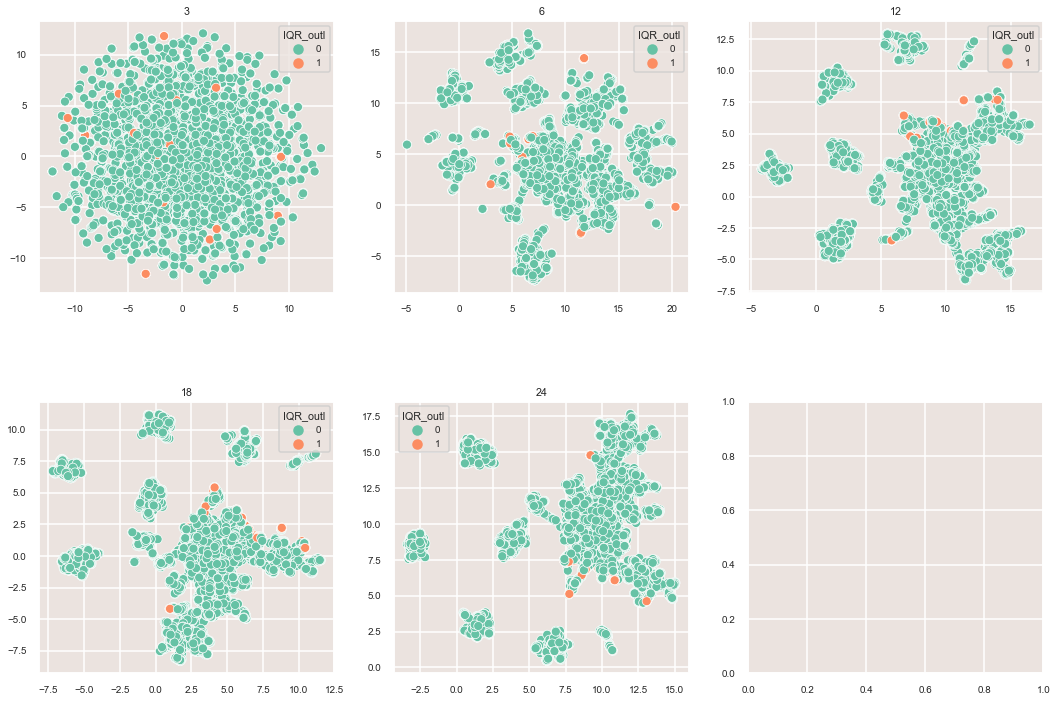

In [162]:
plot_DimRed(UMAP_dict, target=IQR_outl_col['IQR_outl'])

<font color=#0b5bdb> ___Проверка результатов___

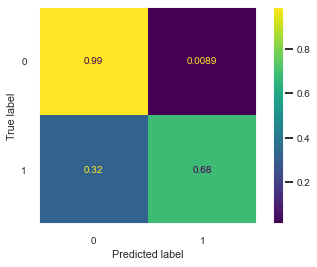

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = IQR_outl_col.astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

## <font color=#0b5bdb> 3.3. Distance_base anomaly

<font color=#0b5bdb> ___Построение оценок___

In [56]:
# Возможно имеет смысл добавить PCA
from sklearn.preprocessing import RobustScaler

class DistanceOutliers_v2(BaseEstimator):
    
    """
    -----------
    Parameters:

    - metric: str, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)

    - percentile: float in range [0, 100], default - 100
        hyperparameter which sets the threshold for anomalies
    
    - clusters_dict: dict (key - number of clusters, value - clusters col (pandas col)), default - None (1 cluster)
        allow to check different variant of clusterization
    """
    
    def __init__(self, clusters_dict={0:None}, metric='euclidean', outl_percent=100):
        self.clusters_dict = clusters_dict
        self.metric = metric
        self.outl_percent = outl_percent
      
    
        
    @staticmethod
    # Функция определения Гиперпараметров для каждого кластера: координаты центра и границы доверия
    def DistanceBase_fit (df, clusters=None, TRESHOLD_PERCENT=100, METRIC = 'euclidean'):
    
        # Учтет наличия/отсутствия кластеризации на входе
        # ___при отсутствии кластеризации все данные размечаются как один кластер
        if clusters is None:
            clusters_local = pd.DataFrame(np.zeros((df.shape[0],1)))
            clusters_local.columns=['clusters']
        else:
            clusters_local = pd.DataFrame(clusters)
            clusters_local.columns=['clusters']
        
        # Формирование елиного df
        X_local = pd.concat([df, clusters_local], axis=1).copy()
        X_local.head()

        centroid = {}  # dict: key=номер кластера
        threshold = {} #
        
        # Определение Гиперпараметров для кажого кластера
        for cluster in clusters_local['clusters'].unique():
            centroid[cluster] = np.mean(X_local[X_local['clusters']==cluster].drop(columns=['clusters']), axis=0).values.reshape(-1, 1).T
            distances_train = cdist(centroid[cluster], X_local[X_local['clusters']==cluster].drop(columns=['clusters']), metric=METRIC).reshape(-1)
            threshold[cluster] = np.percentile(distances_train, TRESHOLD_PERCENT)

        return centroid, distances_train, threshold
    
    
    
    @staticmethod
    # Функция выделения выбросов по входным гиперпараметрам
    def DistanceBase_outl_percent_predictor (df, centroid, outl_percent=5, METRIC = 'euclidean'):
        '''
        outl_percent - доля наблюданий, потенциально являющихся выбросами
        '''
        df_local = df.copy()

        # Определение расстояний относительно каждого центроида
        distances_dict = {}
        for cluster in centroid.keys():
            distances = cdist(centroid[cluster], df_local,  metric=METRIC).reshape(-1)
            distances_dict[cluster] = distances  
        
        # Формирование столбца выбросов
        # ___Объект = выброс, если попадает в outl_percent самых дальних
        # ___Расстояние в оценке = минимальное расстояние объета до кажого центроида
        min_prediction = pd.DataFrame(distances_dict).min(axis=1).sort_values(ascending=False)
        outl = min_prediction.head(int((df_local.shape[0])*outl_percent/100))
        outl_index_list = list(outl.index)
        ### outl_index_list - список выбросов, попавших в outl_percent
        
        #outl_col = pd.DataFrame([1 if i in outl_index_list else 0 for i in df_local.index], columns=['Distance_outl'])
        #outl_col_weighed = pd.DataFrame([outl.loc[i] if i in outl_index_list else 0 for i in df_local.index], columns=['Distance_outl_weighed'])
        
        outl_col = pd.DataFrame(df_local.index, columns=['Distance_outl']).isin(outl_index_list)
        outl_col['Distance_outl'] = outl_col['Distance_outl'].map({False:0, True:1})
        
        outl_col_weighed = outl_col.copy()
        outl_col_weighed.columns = ['Distance_outl_weighed']
        outl_col_weighed.loc[outl_index_list] = outl.loc[outl_index_list]
        
        
        return outl_col, outl_col_weighed
    
    
    
    def fit(self, X):
        
        DATA = X.copy()
        
        # Обучаем scaler
        # ___на выходе имеем df
        self.scaler = RobustScaler()
        self.scaler.fit(DATA)
        DATA_scaled = pd.DataFrame(self.scaler.transform(DATA), columns = self.scaler.get_feature_names_out())
        
        
        # Обучение для кажого варианта кластеризации
        self.centroid_dict = dict()
        self.threshold_dict = dict()

        for i in list(self.clusters_dict.keys()):
            centroid, distances_train, threshold = self.DistanceBase_fit(df=DATA_scaled, 
                                                                         clusters=self.clusters_dict[i], 
                                                                         TRESHOLD_PERCENT=100, # охватываем все объекты
                                                                         METRIC=self.metric)
            self.centroid_dict[i] = centroid
        
    

    def predict(self, X):

        DATA = X.copy()
        
        # Шкалируем данныем обученным скалером
        DATA_scaled = pd.DataFrame(self.scaler.transform(DATA), columns = self.scaler.get_feature_names_out())
    
        # Построение оценок
        # ___Вделяем выбросы относительно каждого центроида
        # ___Объединям и смотрим общие выбросы (объекты, определенные как "выбросы" относительно !каждого центроида)
        predictions_df = pd.DataFrame()
        predictions_weighed_df = pd.DataFrame()
        for idx, i in enumerate(list(self.centroid_dict.keys())):
            predictions, outl_col_weighed = self.DistanceBase_outl_percent_predictor (df=DATA_scaled, 
                                                     centroid=self.centroid_dict[i], 
                                                     outl_percent=self.outl_percent,
                                                     METRIC=self.metric)
            
            predictions.columns = [f'Distance_centr_{idx}']
            outl_col_weighed.columns = [f'Distance_centr_weighed{idx}']
            
            predictions_df = pd.concat([predictions_df , predictions], axis=1)
            predictions_weighed_df = pd.concat([predictions_weighed_df , outl_col_weighed], axis=1)
    
        # Если имеется несколько ипов кластеризации (разное колич. ожид классов), то рассматриваем сквозь все.
        DistanceBase_outl = pd.DataFrame(predictions_df.sum(axis=1))
        DistanceBase_outl[0] = np.where(DistanceBase_outl[0]==DistanceBase_outl[0].max(), 1, 0)
        DistanceBase_outl.columns = ['Distance_outl']
        predictions_weighed_df = predictions_weighed_df/predictions_weighed_df.max()
        
        
        return DistanceBase_outl, predictions_weighed_df

In [68]:
X_to_clean = X_norm_PCA.copy()

# Маркировка выбросов
IQR_dict, bounds_table = get_IQR(X_to_clean, threshold=1.5)
IQR_outl_col_del, IQR_outl_col_weighed_del, union_IQR_del = get_agg_IQR(X_to_clean, IQR_dict, threshold=1)

# Удаление
X_norm_PCA_cleaned = X_to_clean.drop(index=list(union_IQR_del.index))
X_norm_PCA_cleaned.reset_index(drop=True, inplace=True)
print(f'{X_norm_PCA.shape} -> {X_norm_PCA_cleaned.shape}')

(14240, 29) -> (8089, 29)


In [58]:
X_train   = X_norm_PCA_cleaned
X_predict = X_norm_PCA

display(X_train.shape)
display(X_predict.shape)

(8089, 29)

(14240, 29)

In [62]:
# Определение предиктора
predictor= DistanceOutliers_v2(outl_percent=1)

# Обучение
predictor.fit(X_train)

# Предсказание
distance_outliers_col,  distance_outliers_col_weighed  = predictor.predict(X_predict)

# Отчет
outl_cnt = pd.DataFrame(distance_outliers_col.value_counts(), columns=['count'])
percent = pd.DataFrame(distance_outliers_col.value_counts(normalize=True), columns=['%'])*100

display(pd.concat([outl_cnt, percent], axis=1))

count          %
Distance_outl                  
0              14098  99.002809
1                142   0.997191

<font color=#0b5bdb> ___Визуализация___

array([[<AxesSubplot:title={'center':'Distance_centr_weighed0'}>]],
      dtype=object)

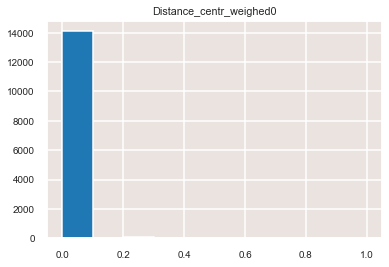

In [63]:
distance_outliers_col_weighed.hist()

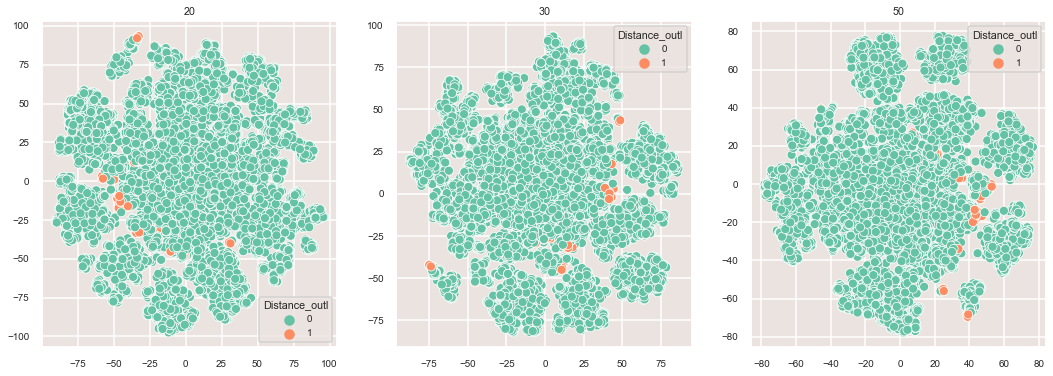

In [66]:
plot_DimRed(TSNE_dict, target=distance_outliers_col['Distance_outl'])

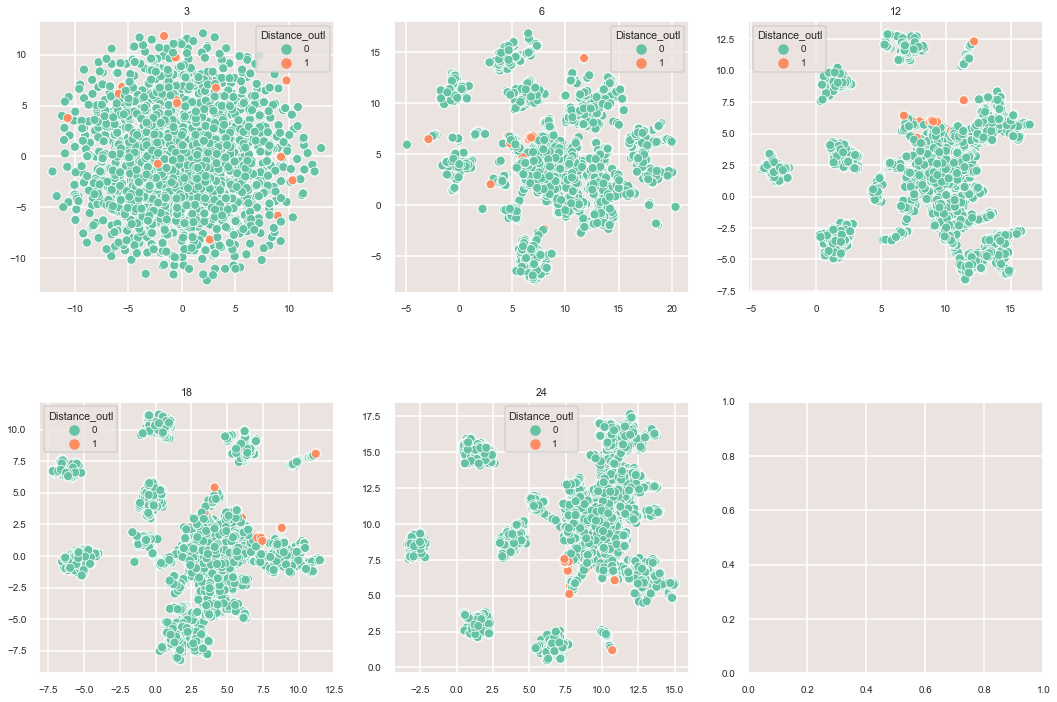

In [163]:
plot_DimRed(UMAP_dict, target=distance_outliers_col['Distance_outl'])

<font color=#0b5bdb> ___Проверка результатов___

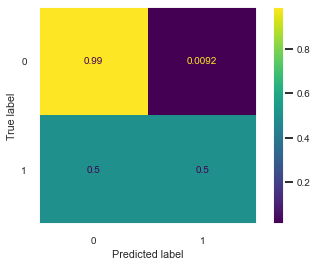

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = distance_outliers_col['Distance_outl'].astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

## <font color=#0b5bdb> 3.4. iforest_base anomaly

<font color=#0b5bdb> ___Построение оценок___

In [74]:
from sklearn.ensemble import IsolationForest

def iforest_scorer(df: pd.DataFrame, n_mean: int=1) -> pd.DataFrame:
    
    iforest_scores = pd.DataFrame()
    
    for i in range(0,n_mean):
        iforest = IsolationForest(n_estimators=100, random_state=i).fit(df)
        iforest_scores = pd.concat([iforest_scores, 
                                    pd.DataFrame(iforest.score_samples(df), columns=[f'iforest_weights_{i}'])], axis=1)
        
    
    
    iforest_scores['iforest_weights'] = iforest_scores.mean(axis=1)
    iforest_scores[['iforest_weights']] = iforest_scores[['iforest_weights']]/iforest_scores[['iforest_weights']].min()
    return iforest_scores[['iforest_weights']]

In [75]:
iforest_outl_col_weighed = iforest_scorer(df=X_norm_PCA_Rob, n_mean=3)

In [93]:
# Отбор целевого % аномалий

outl_percent = 1
outl_index_list = list(iforest_outl_col_weighed['iforest_weights'].sort_values(ascending=False).head(int((df.shape[0])*outl_percent/100)).index)

iforest_outl_col = pd.DataFrame(X_norm_PCA_Rob.index, columns=['iforest_outl']).isin(outl_index_list)
iforest_outl_col['iforest_outl'] = iforest_outl_col['iforest_outl'].map({False:0, True:1})

<font color=#0b5bdb> ___Визуализация___

array([[<AxesSubplot:title={'center':'iforest_weights'}>]], dtype=object)

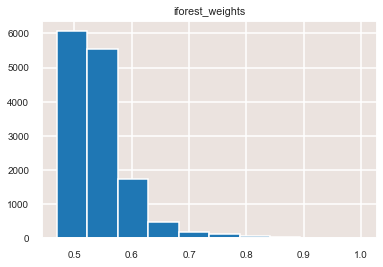

In [85]:
iforest_outl_col_weighed.hist()

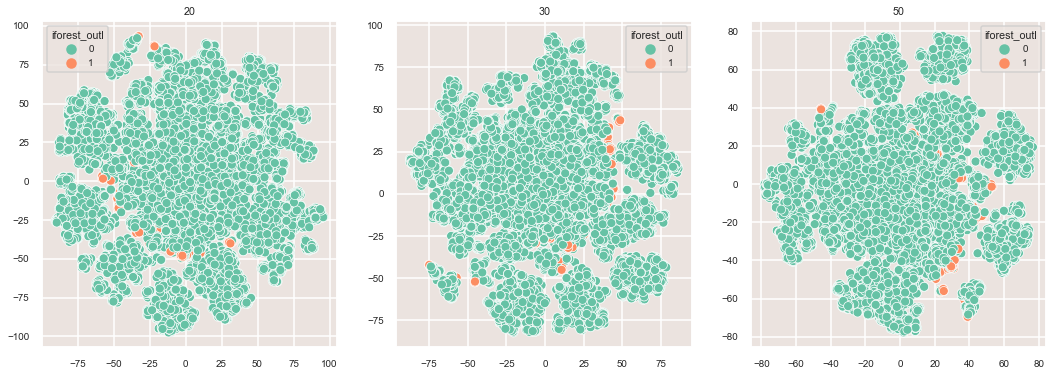

In [86]:
plot_DimRed(TSNE_dict, target=iforest_outl_col['iforest_outl'])

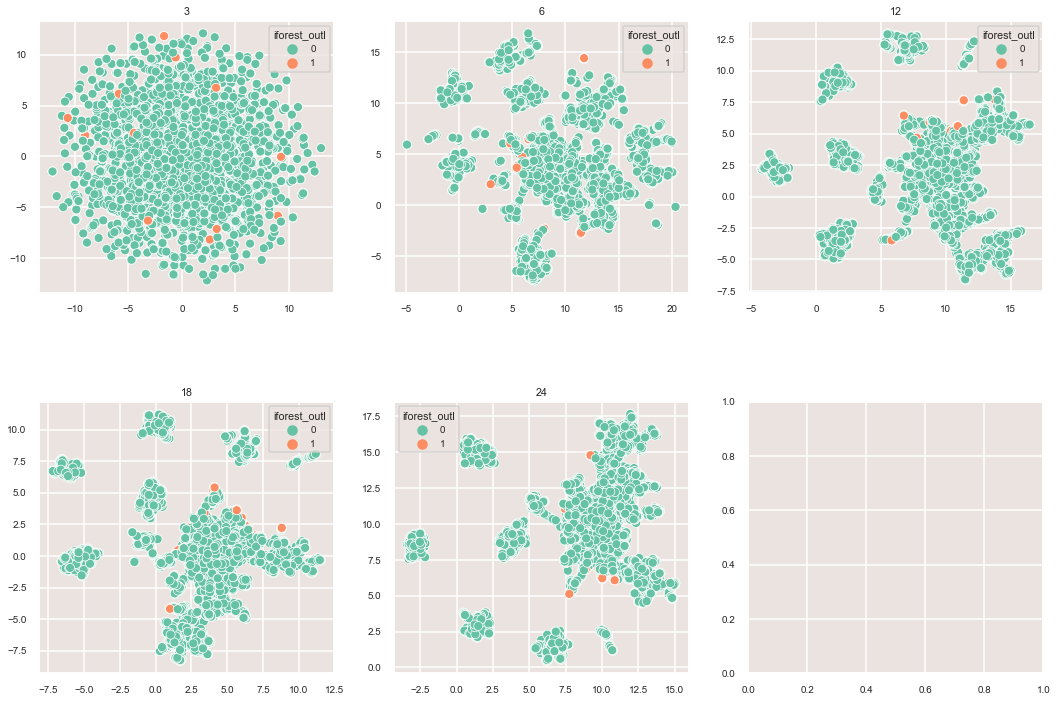

In [164]:
plot_DimRed(UMAP_dict, target=iforest_outl_col['iforest_outl'])

<font color=#0b5bdb> ___Проверка результатов___

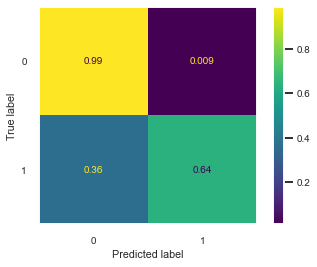

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = iforest_outl_col['iforest_outl'].astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

## <font color=#0b5bdb> 3.5. One_Class_SVM_base anomaly

<font color=#0b5bdb> ___Построение оценок___

In [90]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.01, gamma='auto')
one_class_svm.fit(X_norm_PCA_Rob)
svm_outliers = one_class_svm.predict(X_norm_PCA_Rob)
svm_outliers = pd.DataFrame(np.array([1 if label == -1 else 0 for label in svm_outliers]), columns=['svm_outl'])

<font color=#0b5bdb> ___Визуализация___

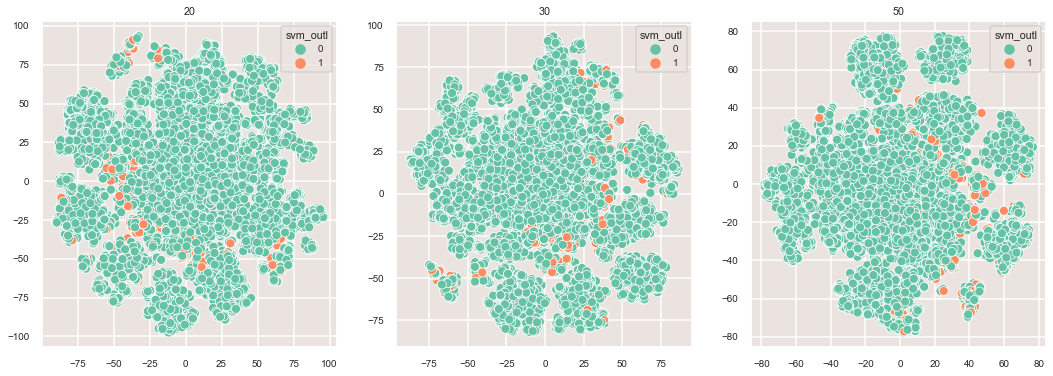

In [91]:
plot_DimRed(TSNE_dict, target=svm_outliers['svm_outl'])

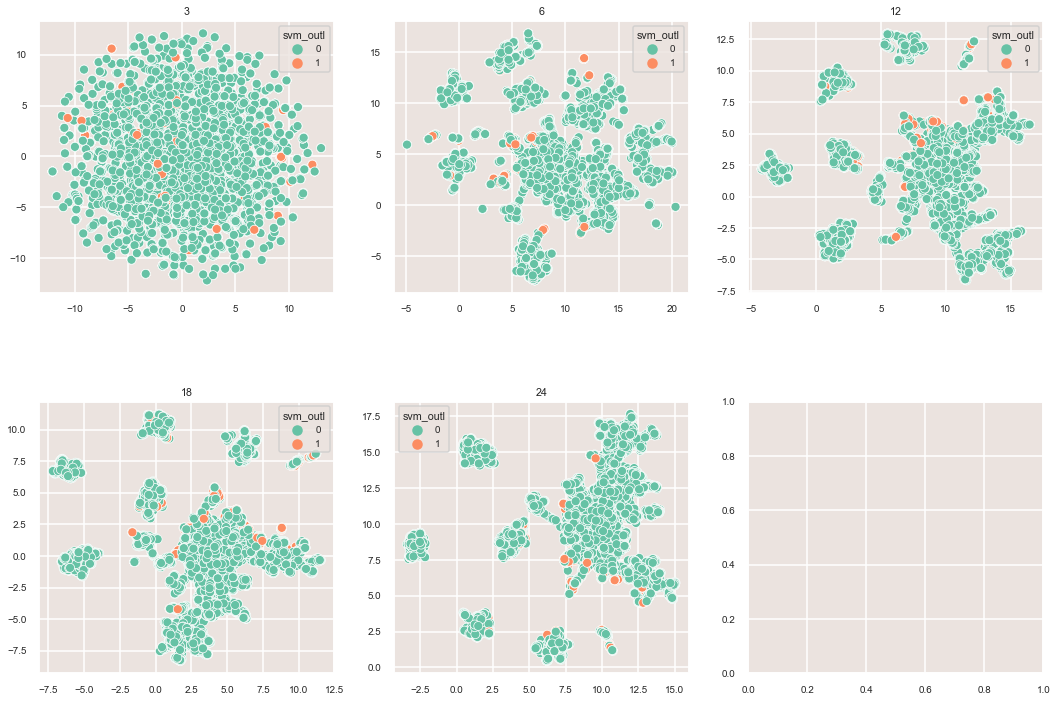

In [165]:
plot_DimRed(UMAP_dict, target=svm_outliers['svm_outl'])

<font color=#0b5bdb> ___Проверка результатов___

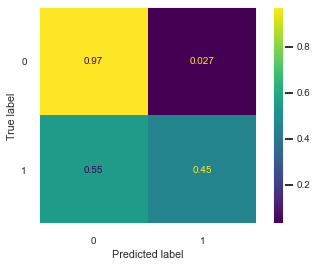

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = svm_outliers['svm_outl'].astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

## <font color=#0b5bdb> 3.6. Density_base anomaly

<font color=#0b5bdb> ___Построение оценок___

In [123]:
from sklearn.cluster import DBSCAN
from  sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

In [124]:
def DBSCAN_explorer_v2(X, EPS_RANGE, SAMPLES_RANGE, METRICS='euclidean'):
    
    DBSCAN_results = pd.DataFrame()

    for eps in EPS_RANGE:
        for n_samples in SAMPLES_RANGE:

            # ___Кластеризация
            model = DBSCAN(eps=eps, min_samples=n_samples, metric=METRICS).fit(X)
            c_labels = model.labels_

            # ___silhouette
            try: sil_ave = silhouette_score(X, c_labels)
            except: sil_ave=0  
            sil_ave = np.where(sil_ave<0, 0, sil_ave)

            # ___noise
            uniq_labels = np.unique(c_labels)
            n_clusters = len(uniq_labels[uniq_labels != -1])

            n_noise_ = list(c_labels).count(-1)
            percent = np.round((100*n_noise_/X.shape[0]), 0)

            # ___Формирование столбца
            local_col = pd.DataFrame([sil_ave, n_clusters, percent])
            local_col.index = ['silhouette', 'clusters', 'noise']
            local_col.columns=[f'eps={eps}, samples={n_samples}']

            # ___Добавление столбца в таблицу
            DBSCAN_results = pd.concat([DBSCAN_results, local_col], axis=1)
    
    return DBSCAN_results.T

def DBSCAN_report(DBSCAN_results: pd.DataFrame, sil_round_val: int=1):
    silhouette_report = DBSCAN_results.sort_values(by='silhouette', ascending=False)['silhouette'].round(sil_round_val).value_counts()
    silhouette_report = pd.DataFrame(silhouette_report)
    
    clusters_report = DBSCAN_results.sort_values(by='clusters', ascending=False)['clusters'].value_counts()
    clusters_report = pd.DataFrame(clusters_report)
    
    noise_report = DBSCAN_results.sort_values(by='noise', ascending=False)['noise'].value_counts()
    noise_report = pd.DataFrame(noise_report)
    
    print('silhouette_report:')
    display(silhouette_report)
    
    print('\n')
    print('clusters_report:')
    display(clusters_report)
    
    print('\n')
    print('noise_report:')
    display(noise_report)

def get_DBSCAN_clusters_outliers (X, EPS, MIN_SAMPLES, METRICS='euclidean'):
    X_local = X.copy()
    
    clusters = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric=METRICS).fit_predict(X_local)
    
    # Построение столбца Outliers
    DSCAN_outliers_col = pd.DataFrame(np.array([1 if label == -1 else 0 for label in clusters]))
    DSCAN_outliers_col.columns = ['DSCAN_outliers']
    
    # Построение столба Clusters
    clusters_col = pd.DataFrame(clusters)
    clusters_col.columns = ['DBSCAN_clusters']
    
    # ___Перечень эдементов относительно которых считаем расстояния (Чистые)
    outliers_index = list(DSCAN_outliers_col[DSCAN_outliers_col['DSCAN_outliers']==1].index)
    X_for_dist = X_local.loc[[i for i in list(X_local.index) if i not in outliers_index]]
    X_for_dist.reset_index(drop=True, inplace=True)
    clusters_for_dist = clusters_col.loc[[i for i in list(X_local.index) if i not in outliers_index]]
    clusters_for_dist.reset_index(drop=True, inplace=True)
    
    # ___Обрабатываем каждый выюрос
    for indx in outliers_index:

        current_outlier = X_local.loc[[indx]]
        distance = pd.DataFrame(cdist(current_outlier.values, X_for_dist)).T
        distance = distance.sort_values(by=0, ascending=True).head(1)

        clusters_col.loc[indx] = clusters_for_dist.loc[distance.index[0]]
    
    return clusters_col, DSCAN_outliers_col

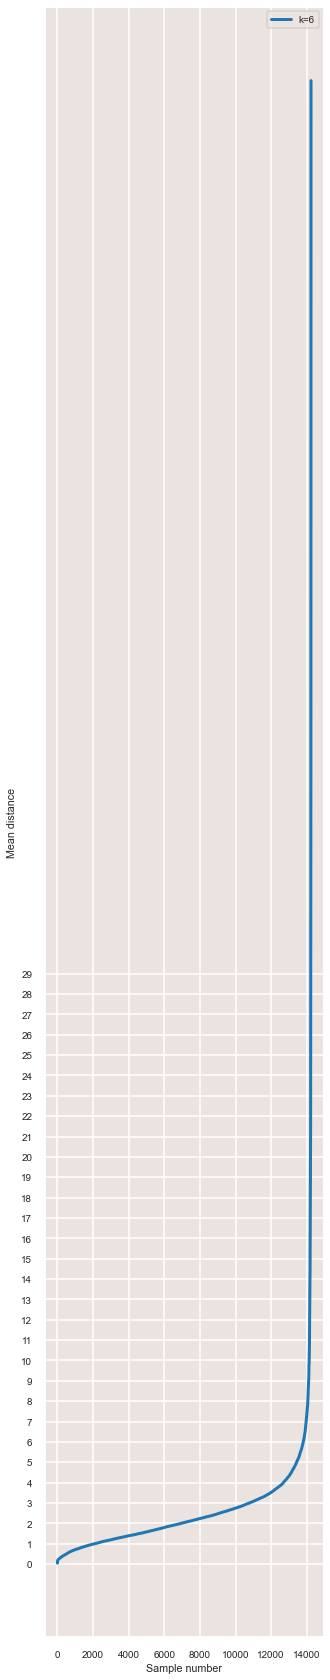

In [114]:
plt.figure(figsize=(5,30))
plt.rcParams.update({'font.size': 10})

MAX_MEAN = 0
k_samples = [6]

kd_tree = KDTree(X_norm_PCA_Rob)

for k_sample in k_samples:
    dist, _ = kd_tree.query(X_norm_PCA_Rob, k=k_sample, return_distance=True, sort_results=True)  
    # Remove distance to self point
    dist = np.delete(dist, 0, 1)
    sorted_m_dist = np.sort(dist.mean(axis=1))
    MAX_MEAN = max(max(sorted_m_dist), MAX_MEAN)
    plt.plot(np.arange(len(sorted_m_dist)),sorted_m_dist,label=f"k={k_sample}", linewidth=3)
    
    
plt.xlabel('Sample number', )
plt.ylabel('Mean distance')
plt.yticks(ticks=[x / 1 for x in range(0, 30, 1)])
plt.legend()
plt.grid(True)
plt.show()

In [128]:
EPS_RANGE=[4, 6, 10]#np.arange(4,10,1).round(2)
SAMPLES_RANGE=[3, 6, 10]

DBSCAN_results = DBSCAN_explorer_v2(X_norm_PCA_Rob, EPS_RANGE=EPS_RANGE, SAMPLES_RANGE=SAMPLES_RANGE, METRICS='euclidean')

In [129]:
DBSCAN_results[DBSCAN_results['noise']>0.1].sort_values(by='silhouette', ascending=False)

silhouette  clusters  noise
eps=10, samples=6     0.810791       1.0    1.0
eps=10, samples=10    0.804874       1.0    1.0
eps=6, samples=10     0.678197       1.0    3.0
eps=10, samples=3     0.676766       4.0    1.0
eps=6, samples=6      0.621923       4.0    3.0
eps=6, samples=3      0.397323      11.0    2.0
eps=4, samples=10     0.238525       2.0   11.0
eps=4, samples=6      0.237859       2.0   10.0
eps=4, samples=3      0.119437      20.0    9.0

In [130]:
clusters_col, DSCAN_outliers_col = get_DBSCAN_clusters_outliers(X_norm_PCA_Rob, EPS=10, MIN_SAMPLES=10)
display(clusters_col.value_counts())
display(DSCAN_outliers_col.value_counts())

DBSCAN_clusters
0                  14240
dtype: int64

DSCAN_outliers
0                 14134
1                   106
dtype: int64

In [131]:
clusters_col_2, DSCAN_outliers_col_2 = get_DBSCAN_clusters_outliers(X_norm_PCA_Rob, EPS=10, MIN_SAMPLES=3)
display(clusters_col_2.value_counts())
display(DSCAN_outliers_col_2.value_counts())

DBSCAN_clusters
0                  14220
3                     10
1                      6
2                      4
dtype: int64

DSCAN_outliers
0                 14156
1                    84
dtype: int64

In [132]:
DSCAN_outliers_col_summary = (DSCAN_outliers_col + DSCAN_outliers_col_2)['DSCAN_outliers'].apply(lambda x: 0 if x < 1 else 1)
DSCAN_outliers_col_summary.value_counts()

0    14134
1      106
Name: DSCAN_outliers, dtype: int64

<font color=#0b5bdb> ___Визуализация___

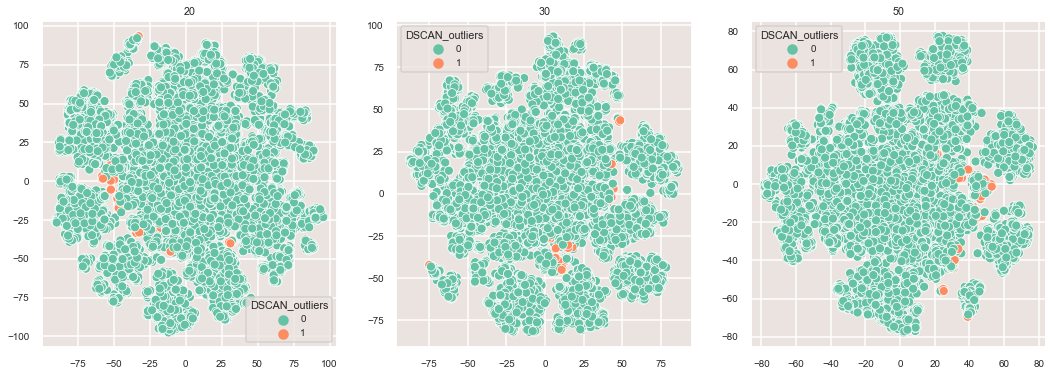

In [134]:
plot_DimRed(TSNE_dict, target=DSCAN_outliers_col_summary)

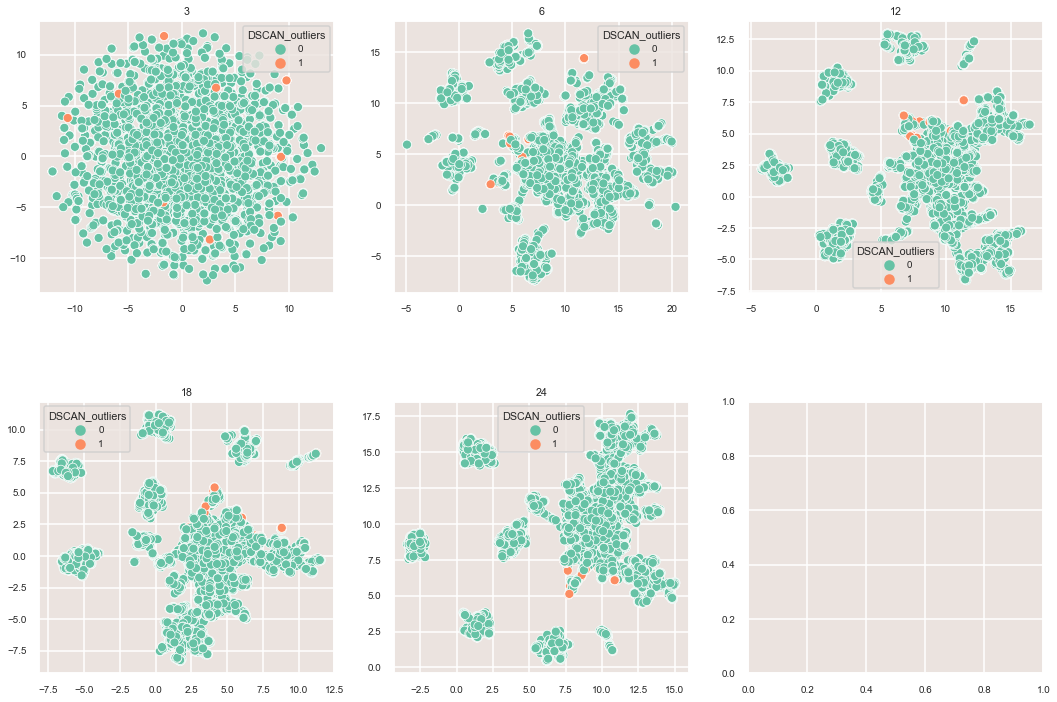

In [166]:
plot_DimRed(UMAP_dict, target=DSCAN_outliers_col_summary)

<font color=#0b5bdb> ___Проверка результатов___

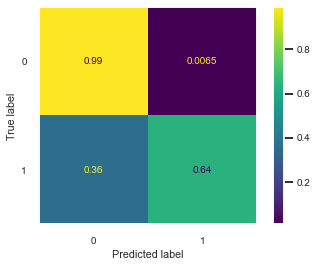

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                      y_pred = DSCAN_outliers_col_summary.astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

## <font color=#0b5bdb> 3.7. Summary anomaly

<font color=#0b5bdb> ___Вариант №1___

 - Отберем не более 1% аномалий

In [167]:
summary = pd.concat([distance_outliers_col, 
                     IQR_outl_col, 
                     DSCAN_outliers_col_summary, 
                     iforest_outl_col,
                     svm_outliers], axis=1)
summary_outlier_score = summary.mean(axis=1)
simple_score = summary_outlier_score.apply(lambda x: 0 if x < 0.5 else 1)
simple_score.value_counts(normalize=True)

0    0.991503
1    0.008497
dtype: float64

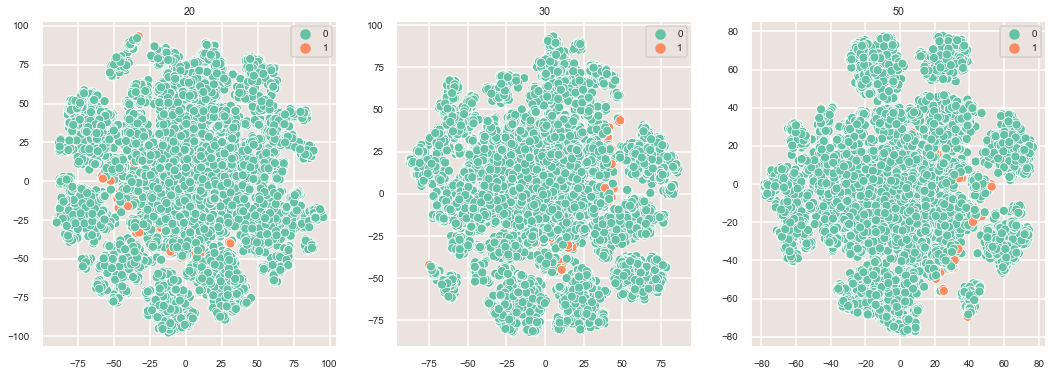

In [168]:
plot_DimRed(TSNE_dict, target=simple_score)

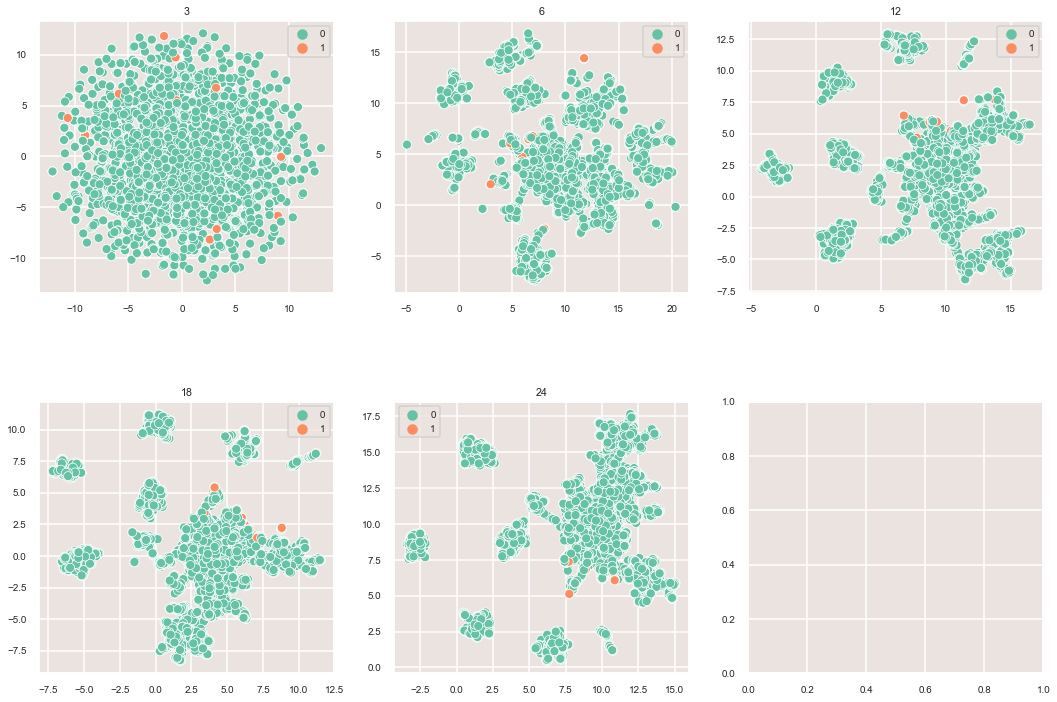

In [169]:
plot_DimRed(UMAP_dict, target=simple_score)

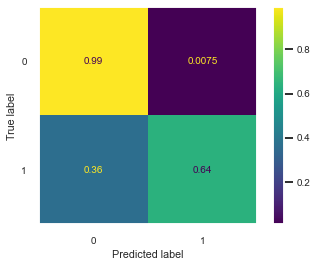

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = simple_score.astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()

<font color=#0b5bdb> ___Вариант №2___

 - Отберем все объекты, помеченные как аномалии

In [170]:
summary = pd.concat([distance_outliers_col, 
                     IQR_outl_col, 
                     DSCAN_outliers_col_summary, 
                     iforest_outl_col,
                     svm_outliers], axis=1)
summary_outlier_score = summary.mean(axis=1)
simple_score = summary_outlier_score.apply(lambda x: 0 if x < 0.1 else 1)
simple_score.value_counts(normalize=True)

0    0.963694
1    0.036306
dtype: float64

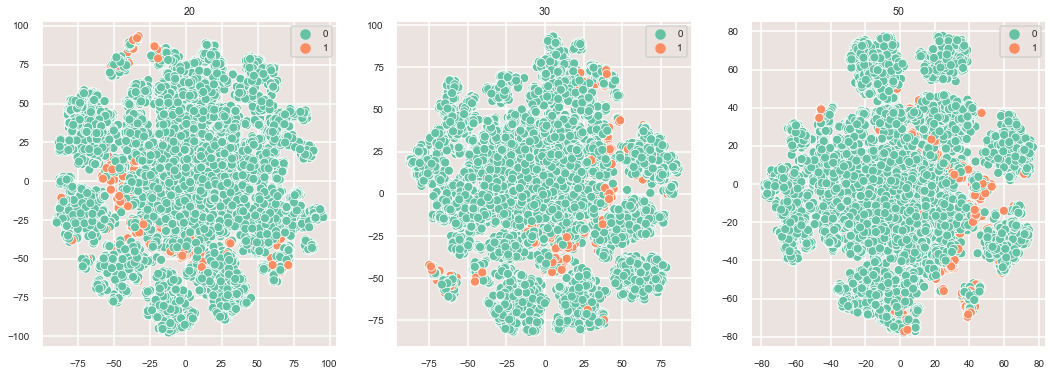

In [171]:
plot_DimRed(TSNE_dict, target=simple_score)

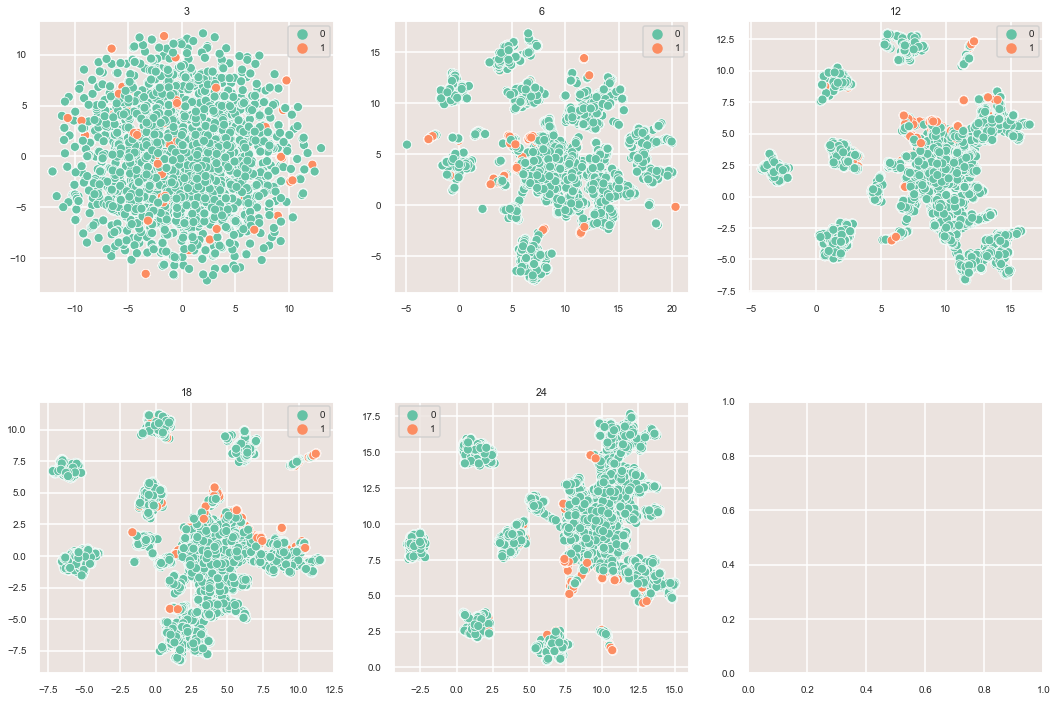

In [172]:
plot_DimRed(UMAP_dict, target=simple_score)

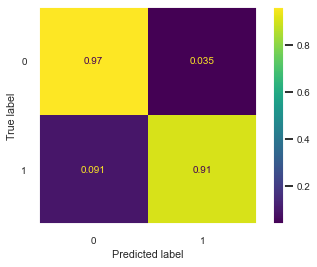

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true = y_true,
                 y_pred = simple_score.astype(str), normalize='true')

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid()